In [1]:
# presentation needs intro (with background on the problem beyond what she has in the description), methodology, performance, conclusion
# between 10-15 mins, no cut off

In [2]:
# import required libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn import model_selection
from sklearn.model_selection import train_test_split, cross_val_score, KFold, learning_curve, StratifiedKFold
from sklearn.metrics import confusion_matrix, make_scorer, accuracy_score, classification_report, roc_curve, auc, confusion_matrix, mean_squared_error, r2_score, mean_absolute_error, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
import itertools
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
import xgboost as xgb
from xgboost import XGBClassifier

# **Load and Inspect Dataset**

In [3]:
# load the dataset
data = pd.read_csv('/Users/bilalmohideen/Downloads/Project1_pharmacy_claims_data.csv')
# take a peak at the dataset using head()
data.head()

,ClaimID,ClaimantID,PharmacyName,PharmacyChainName,City,Province,Postcode,DIN,TherapyClass,DaysOfSupply,Qty,DIN_Submitted,DIN_Paid,DispenseFee_Submitted,DispenseFee_Paid,TotalPaid,IsFraud
0,C1006252,P84717,HealthRx Professional,HealthRx,Calgary,AB,NaN,2682149,Cholesterol Reducers,87.0,73.0,6.820017,6.820017,13.037284,13.037284,19.857301,0
1,C1004684,P76788,PharmaCare Central,PharmaCare,Edmonton,AB,T5K 2N1,2815866,Gastrointestinal,NaN,122.0,12.176033,12.176033,14.521871,14.521871,26.697904,0
2,C1001731,P14260,CarePharmacy Direct,CarePharmacy,Quebec City,QC,G1R 4P3,2427607,Antihypertensives,13.0,88.0,4.250368,4.250368,NaN,10.873956,15.124324,0
3,C1004742,P36503,PharmaCare Central,PharmaCare,Calgary,AB,T3H 4T9,2349672,Antidiabetics,35.0,79.0,3.765769,3.765769,8.721394,8.721394,12.487163,0
4,C1004521,P50669,WellPharm City,WellPharm,Ottawa,ON,K1V 8Y9,2127653,Antibiotics,63.0,50.0,1.357430,1.357430,10.213377,10.213377,11.570808,0


# **Investigating Data**

Through this quick overview of the dataset, we see that there are certain variables that contain missing values. These variables include PharmacyName, Postcode, TherapyClass, DaysofSupply, Qty, DIN_Submitted, and DisepenseFee_Submitted.

In [4]:
# summarize the data with info() and describe
print(data.info())
print(data.describe)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   ClaimID                10000 non-null  object 
 1   ClaimantID             10000 non-null  object 
 2   PharmacyName           9793 non-null   object 
 3   PharmacyChainName      10000 non-null  object 
 4   City                   10000 non-null  object 
 5   Province               10000 non-null  object 
 6   Postcode               9632 non-null   object 
 7   DIN                    10000 non-null  int64  
 8   TherapyClass           9687 non-null   object 
 9   DaysOfSupply           9707 non-null   float64
 10  Qty                    9800 non-null   float64
 11  DIN_Submitted          9893 non-null   float64
 12  DIN_Paid               10000 non-null  float64
 13  DispenseFee_Submitted  9533 non-null   float64
 14  DispenseFee_Paid       10000 non-null  float64
 15  Tot

## **Checking for Missing Values**

We see that less than 20% of the dataset contain missing values. When we identified the % missing for specific variables, we see that all of them have less than 5% missing data. Furthermore, the % missing for each variable is similar between the non-fraud and fraud groups, suggesting that none of the missingness is correlated with fraud status. Given this insight, we decided to go with the complete case analysis approach by removing all rows that contained missing values.


In [5]:
# See the % of total rows that have null values
print(data[data.isnull().any(axis=1)].shape[0] / data.shape[0]*100)

18.16


In [6]:
# View dimensions of dataset
print("Shape of dataset:", data.shape)
print("\nColumns & Types:")
print(data.dtypes)

# Check for missing values
missing_null = data.isnull().sum()
if missing_null.max() > 0:
  print("\nMissing Values Count (based on null values):")
  print(missing_null[missing_null > 0].sort_values(ascending=False))

  # % Missing due to null
  missing_percent = (missing_null / data.shape[0]) * 100
  print(missing_percent.sort_values(ascending=False))
else:
  print("\nNo missing values based on null")

# % Missing based on 0
missing_0 = (data.iloc[:, :-1] == 0).sum()
if missing_0.max() > 0:
  print("\nMissing Values Count (based on 0):")
  print(missing_0.sort_values(ascending=False))

  # % Missing due to 0
  missing_percent_0 = (missing_0 / data.shape[0]) * 100
  print("\nPercentage:", missing_percent_0.sort_values(ascending=False))
else:
  print("\nNo missing values based on 0")

# Check target class balance
print("\nFraud Distribution:")
print(data['IsFraud'].value_counts())

Shape of dataset: (10000, 17)

Columns & Types:
ClaimID                   object
ClaimantID                object
PharmacyName              object
PharmacyChainName         object
City                      object
Province                  object
Postcode                  object
DIN                        int64
TherapyClass              object
DaysOfSupply             float64
Qty                      float64
DIN_Submitted            float64
DIN_Paid                 float64
DispenseFee_Submitted    float64
DispenseFee_Paid         float64
TotalPaid                float64
IsFraud                    int64
dtype: object

Missing Values Count (based on null values):
DispenseFee_Submitted    467
Postcode                 368
TherapyClass             313
DaysOfSupply             293
PharmacyName             207
Qty                      200
DIN_Submitted            107
dtype: int64
DispenseFee_Submitted    4.67
Postcode                 3.68
TherapyClass             3.13
DaysOfSupply             

In [7]:
# make a copy of the dataset to check for if there are missing values
df2 = data.copy()
df2['is_missing_TherapyClass'] = df2['TherapyClass'].isna().astype(int)
df2['is_missing_PharmacyName'] = df2['PharmacyName'].isna().astype(int)
df2['is_missing_Postcode'] = df2['Postcode'].isna().astype(int)
df2['is_missing_Qty'] = df2['Qty'].isna().astype(int)
df2['is_missing_DIN_Submitted'] = df2['DIN_Submitted'].isna().astype(int)
df2['is_missing_DispenseFee_Submitted'] = df2['DispenseFee_Submitted'].isna().astype(int)

In [8]:
missing_flags = [col for col in df2.columns if col.startswith('is_missing_')]
# Compare missing rates between fraud vs non-fraud
df2.groupby('IsFraud')[missing_flags].mean().T.sort_values(by=1, ascending=False)

IsFraud,0,1
is_missing_TherapyClass,0.030842,0.040
is_missing_DispenseFee_Submitted,0.047263,0.036
is_missing_Postcode,0.037474,0.024
is_missing_Qty,0.020000,0.020
is_missing_PharmacyName,0.020842,0.018
is_missing_DIN_Submitted,0.010842,0.008


With our complete case analysis approach, we end up with a dataset containing 8184 records with 17 features.

In [9]:
# Select only complete rows
complete_data = data.dropna()
print("Shape of dataset:", complete_data.shape)

Shape of dataset: (8184, 17)


# Exploratory Data Analysis (EDA)

In [10]:
# Create a function that prints out summary statistics of a given dataset.
# For the numerical columns, it prints out the count, mean, standard deviation, minimum, 25%, 50%, 75%, and maximum.
# A histogram and boxplot is created for each numerical variable to show the distribution.
# For the categorical columns, it prints out the frequency of each unique value.
# A bar chart is created for each categorical variable to show the distribution.
def eda(df):
    int_columns = df.dtypes[df.dtypes == 'int64'].index.tolist()
    object_columns = df.dtypes[df.dtypes == 'object'].index.tolist()

    for column in int_columns:
        print('Summary statistics of Annual ' + column + ':', df[column].describe(), sep = '\n')
        plt.figure(figsize = (8, 4))
        sns.histplot(data = df, x = column, color = '#1AA7EC', edgecolor = 'white', bins = 30)
        plt.title(f"Distribution of {column}")
        plt.show()
        print('\n')

        plt.figure(figsize = (8, 4))
        sns.boxplot(data = df, x = column, color = '#1AA7EC')
        plt.title(f"Distribution of {column}")
        plt.show()
        print('\n')

    for column in object_columns:
        print(f'Summary statistics of Annual, {column}:', f'Number of Unique Values: {len(df[column].unique())}', df[column].value_counts(), sep = '\n')
        plt.figure(figsize = (8, 4))
        sns.countplot(data = df, x = column, color = '#1AA7EC', edgecolor = 'white')
        plt.title(f"Distribution of {column}")
        if len(df[column].unique()) > 5:
          plt.xticks(rotation = 90)
        plt.show()
        print('\n')

### **EDA with full dataset, prior to complete data analysis approach**



Summary statistics of Annual IsFraud:
count    10000.000000
mean         0.050000
std          0.217956
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: IsFraud, dtype: float64


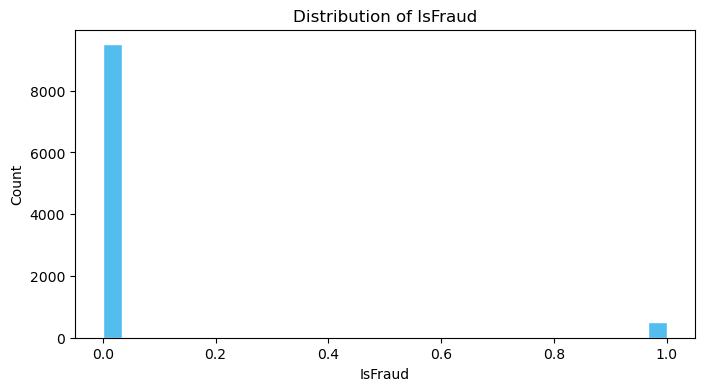

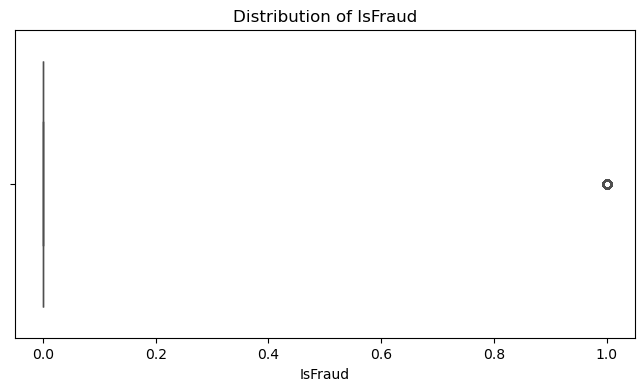



Summary statistics of Annual, PharmacyName:
Number of Unique Values: 21
PharmacyName
WellPharm City            526
PharmaCare Downtown       524
PharmaCare Central        521
MediPlus Community        519
MediPlus Health           516
CarePharmacy Direct       513
HealthRx Prime            511
MediPlus Center           503
CarePharmacy First        501
WellPharm Care            490
HealthRx Main             489
WellPharm Total           488
PharmaCare Express        480
HealthRx Complete         480
PharmaCare Plus           479
HealthRx Professional     478
CarePharmacy Pro          469
CarePharmacy Essential    447
WellPharm Wellness        434
MediPlus Family           425
Name: count, dtype: int64


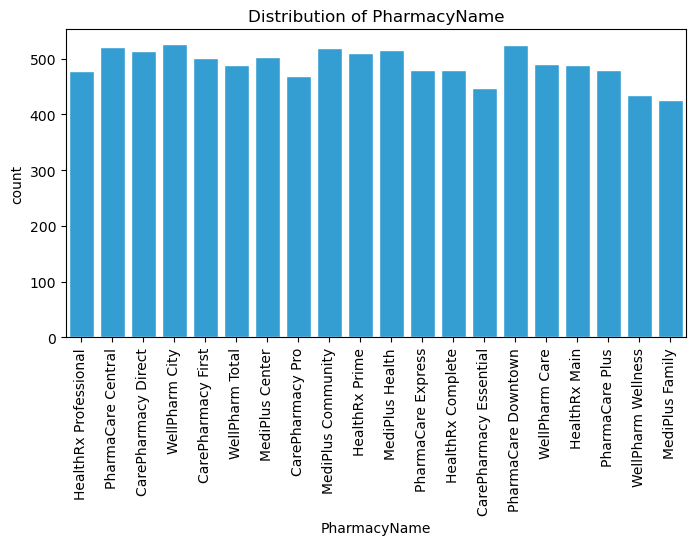



Summary statistics of Annual, PharmacyChainName:
Number of Unique Values: 5
PharmacyChainName
PharmaCare      2037
HealthRx        1998
MediPlus        1997
CarePharmacy    1986
WellPharm       1982
Name: count, dtype: int64


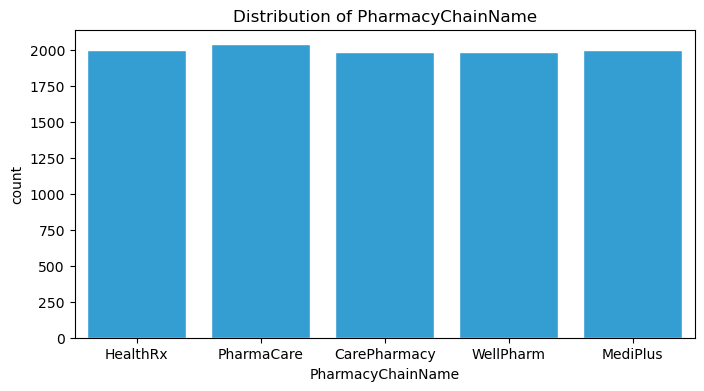



Summary statistics of Annual, City:
Number of Unique Values: 8
City
Montreal       1308
Ottawa         1293
Edmonton       1278
Quebec City    1238
Winnipeg       1236
Calgary        1232
Toronto        1228
Vancouver      1187
Name: count, dtype: int64


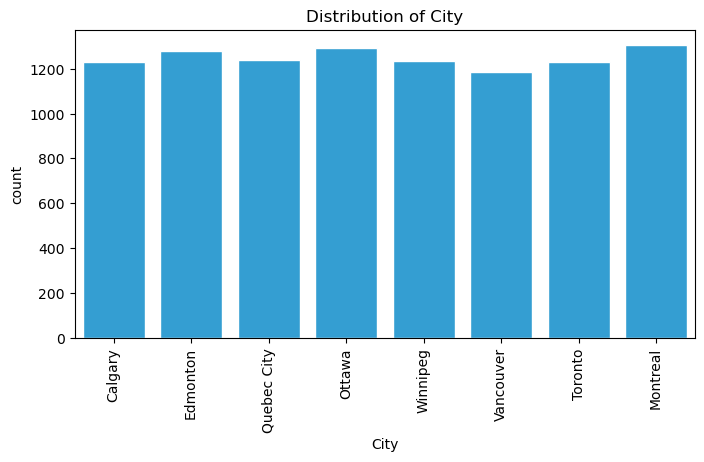



Summary statistics of Annual, Province:
Number of Unique Values: 5
Province
QC    2546
ON    2521
AB    2510
MB    1236
BC    1187
Name: count, dtype: int64


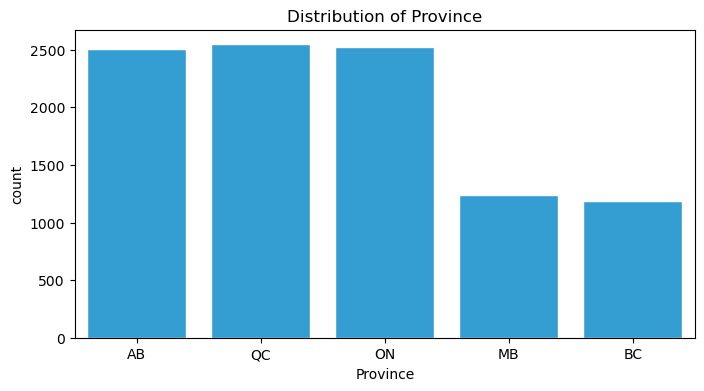



Summary statistics of Annual, Postcode:
Number of Unique Values: 33
Postcode
H2Y 1Z8    337
H3A 1A9    335
K1P 5G3    335
R3M 2L7    330
T3B 0C5    327
T6E 5V8    324
T5J 2R4    320
T6C 4N9    316
G1K 7P4    315
K1V 8Y9    314
M5H 2N2    306
M4C 1M2    304
K1A 0A6    302
K2P 2G8    300
G2B 1V4    300
H3B 2Y7    299
V5K 2K6    293
T2G 5R7    293
H2X 1Y6    292
R2C 3T4    292
G1V 2M2    291
G1R 4P3    291
T3H 4T9    290
M6J 2R4    289
R3B 1P2    288
M5V 2H1    287
V6C 3E1    286
V7Y 1C6    284
R3C 0V1    278
V6B 1S5    274
T2P 1J9    271
T5K 2N1    269
Name: count, dtype: int64


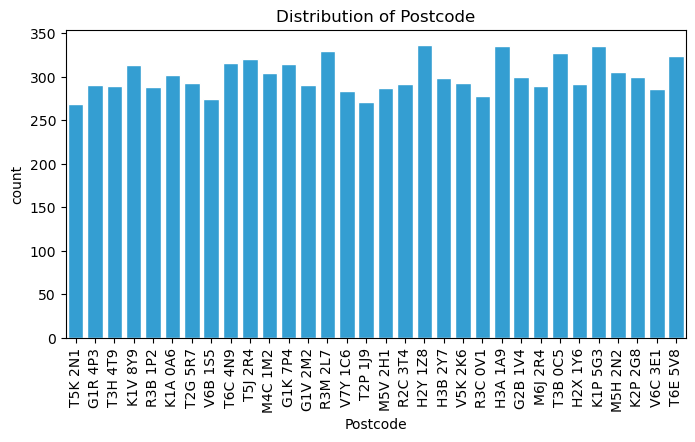



Summary statistics of Annual, TherapyClass:
Number of Unique Values: 11
TherapyClass
Hormonal                1038
Antiinflammatories      1007
Cholesterol Reducers     989
Gastrointestinal         988
Analgesics               960
Antidiabetics            956
Respiratory              956
Antidepressants          944
Antihypertensives        935
Antibiotics              914
Name: count, dtype: int64


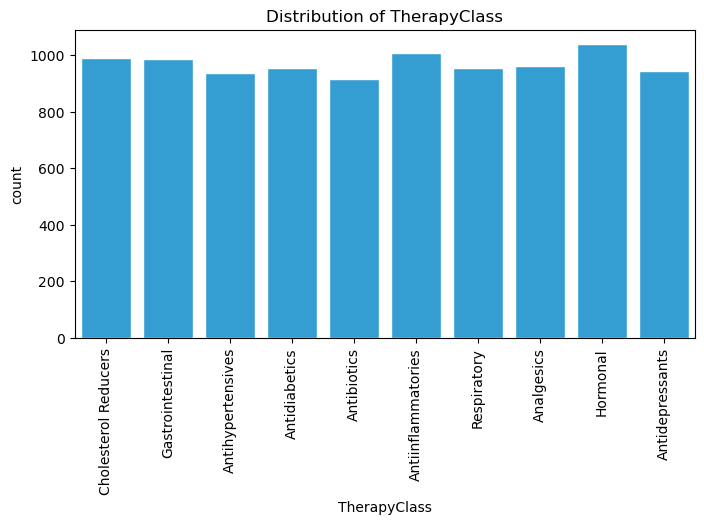

In [11]:
# use the EDA function with ClaimID, ClaimantID, and DIN
eda(data.drop(['ClaimID', 'ClaimantID', 'DIN'], axis = 1))

### **EDA with complete dataset**

In addition, we want to bring attention to this issue of class imbalance within our dataset. Fraud status is our outcome variable, and 0 represents non fraudulent cases while 1 represents fraudulent cases. Within our complete analysis dataset, we saw that approximately 95% of records are non-fraudulent. This imbalance significantly affects model performance, and it’s important to keep this context in mind.

Distribution of Fraud Status in Complete Dataset:

 IsFraud
0    7764
1     420
Name: count, dtype: int64 
 IsFraud
0    0.94868
1    0.05132
Name: proportion, dtype: float64 



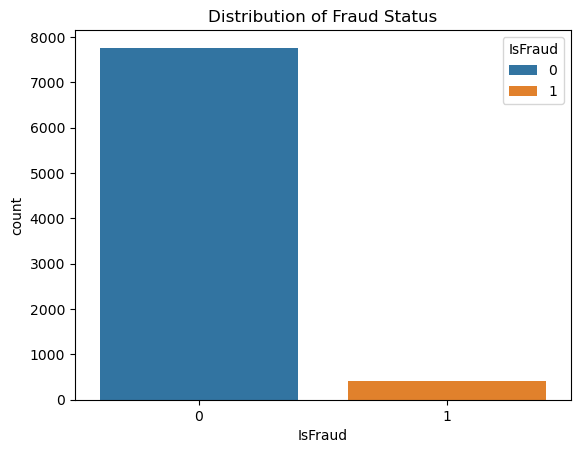

In [12]:
# Check distribution of Fraud Status in Complete Dataset
print('Distribution of Fraud Status in Complete Dataset:')
print('\n', complete_data['IsFraud'].value_counts(), '\n', complete_data['IsFraud'].value_counts(normalize = True), '\n')
sns.countplot(data = complete_data, x = 'IsFraud', hue = 'IsFraud')
plt.title("Distribution of Fraud Status")
plt.show()

In [13]:
# Calculate pack unit
complete_data.loc[:, 'pack_unit'] = complete_data['DIN_Submitted'] / complete_data['Qty']
# Checking distribution of pack unit based on fraud status
complete_data.groupby('IsFraud')['pack_unit'].describe()

/var/folders/f_/2kzwljcd7dv87v_zbqfnvfr00000gn/T/ipykernel_13873/288511562.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  complete_data.loc[:, 'pack_unit'] = complete_data['DIN_Submitted'] / complete_data['Qty']


,count,mean,std,min,25%,50%,75%,max
IsFraud,,,,,,,,
0,7764.0,0.055492,0.02590,0.009377,0.033799,0.055630,0.077014,0.109350
1,420.0,0.623325,0.42383,0.030608,0.267407,0.528151,0.895581,2.097691


In [14]:
def eda_by_fraud(df):
    # Get numerical and categorical columns
    int_columns = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
    object_columns = df.select_dtypes(include='object').columns.tolist()

    # Manually remove 'IsFraud' from the numerical columns list
    if 'IsFraud' in int_columns:
        int_columns.remove('IsFraud')

    for column in int_columns:
        print(f"\nSummary statistics of {column} by IsFraud:")
        print(df.groupby('IsFraud')[column].describe())

        # Histogram with hue by fraud status
        plt.figure(figsize = (8, 4))
        sns.histplot(data = df, x = column, hue = 'IsFraud', bins = 30)
        plt.title(f"Distribution of {column} by Fraud Status")
        plt.show()
        print('\n')

        # Boxplot by fraud status
        plt.figure(figsize = (6, 4))
        sns.boxplot(data = df, x = 'IsFraud', y = column, hue = 'IsFraud')
        plt.title(f"{column} by Fraud Status")
        plt.show()
        print('\n')

    for column in object_columns:
        print(f"\nValue counts for {column} by Fraud Status:")
        print(df.groupby('IsFraud')[column].value_counts())
        print(df.groupby('IsFraud')[column].value_counts(normalize = True))

        if len(df[column].unique()) <= 15:
            plt.figure(figsize = (8, 4))
            sns.countplot(data = df, x = column, hue = 'IsFraud')
            plt.title(f"{column} Distribution by Fraud Status")
            plt.xticks(rotation = 45)
            plt.show()
        print('\n')

Below are our EDA results. For all variables, we colour coded the results by Fraud status to identify which features may be key indicators for detecting fraudulent claims. Days of Supply and Quantity both show very similar distributions across both groups. The means and ranges are almost identical, indicating that these were not strong variables. Submitted and paid dispensing fees also showed minimal variation between fraud and non-fraud claims, suggesting limited predictive value. DIN Submitted and Paid, which represents the submitted and reimbursed drug costs show drastic differences between fraud and non-fraud claims. Fraudulent claims had much higher averages and more extreme outliers, as seen in the histograms and boxplots. This is consistent with known fraud patterns. Total paid and pack unit also stood out, the latter which we had calculated using the aforementioned formula. Fraudulent claims had over 4x higher TotalPaid amount on average, compared to non fraudulent claims. More importantly, we can see that PackUnit is significantly higher in fraud cases. The mean jumps from 0.06 to 0.62, and the upper range more than doubles. This highlights its role as a primary fraud indicator.


Shifting to categorical features, at the province level, Ontario has the highest rate of fraud at over 27%, while Manitoba has the lowest. At the city level, Toronto leads with the highest fraud percentage. While this may reflect fraud patterns, we also understand that they may also be reflective of the population size. For pharmacy chains, HealthRx had the highest fraud rate, and CarePharmacy the lowest. Therapy class showed more meaningful variation: Antidepressants topping the list at 12.86%, while Gastrointestinal drugs had the lowest at just over 8%.



Summary statistics of DaysOfSupply by IsFraud:
          count       mean        std  min    25%   50%   75%   max
IsFraud                                                            
0        7764.0  48.580371  24.303427  7.0  27.00  48.0  70.0  90.0
1         420.0  49.033333  24.688007  7.0  26.75  50.0  71.0  90.0


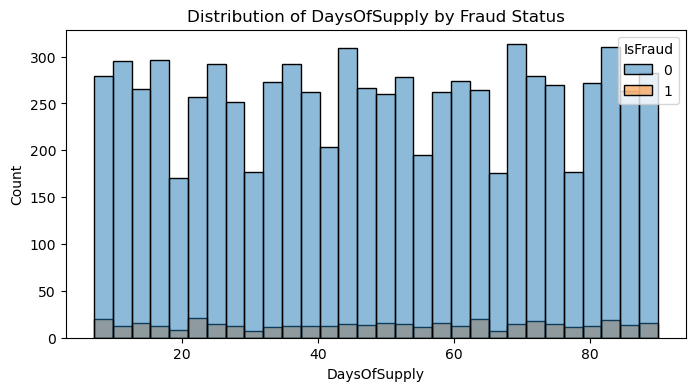

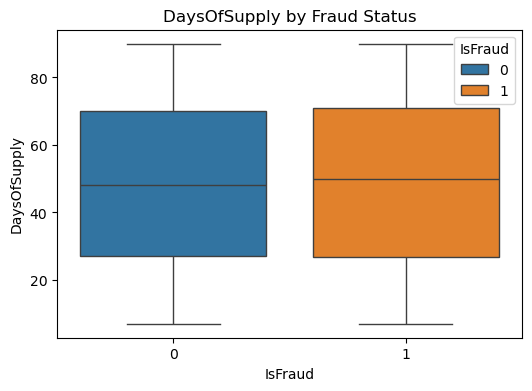




Summary statistics of Qty by IsFraud:
          count       mean        std   min    25%   50%     75%    max
IsFraud                                                                
0        7764.0  95.417955  49.937734  10.0  52.00  95.0  139.00  180.0
1         420.0  92.602381  48.508902  10.0  51.75  90.0  133.25  180.0


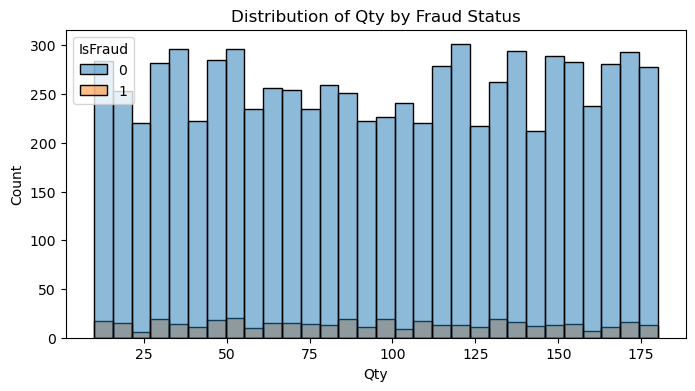

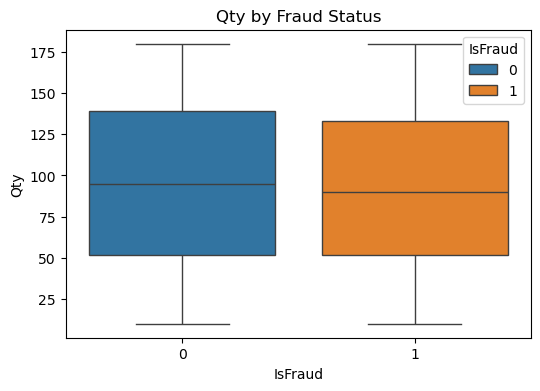




Summary statistics of DIN_Submitted by IsFraud:
          count       mean        std       min        25%        50%  \
IsFraud                                                                 
0        7764.0   5.284921   3.926672  0.126735   2.091616   4.300650   
1         420.0  58.117752  53.583730  0.676272  18.200473  38.805386   

               75%         max  
IsFraud                         
0         7.698250   19.464382  
1        83.286703  296.998518  


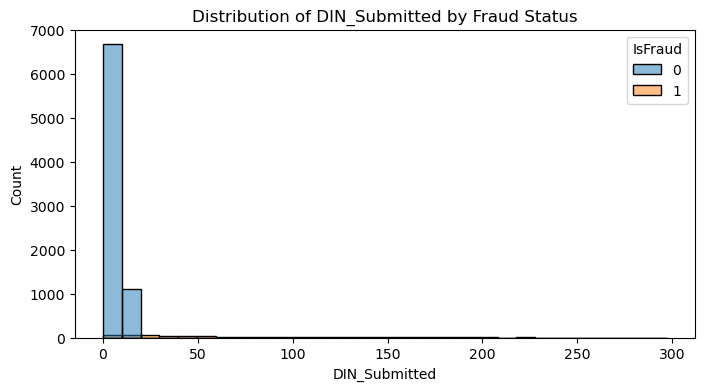

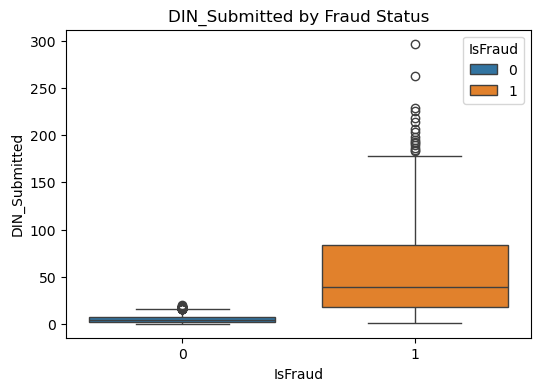




Summary statistics of DIN_Paid by IsFraud:
          count       mean        std       min        25%        50%  \
IsFraud                                                                 
0        7764.0   5.284921   3.926672  0.126735   2.091616   4.300650   
1         420.0  58.117752  53.583730  0.676272  18.200473  38.805386   

               75%         max  
IsFraud                         
0         7.698250   19.464382  
1        83.286703  296.998518  


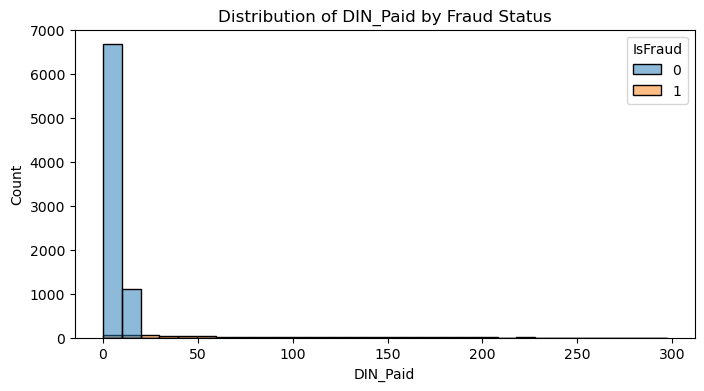

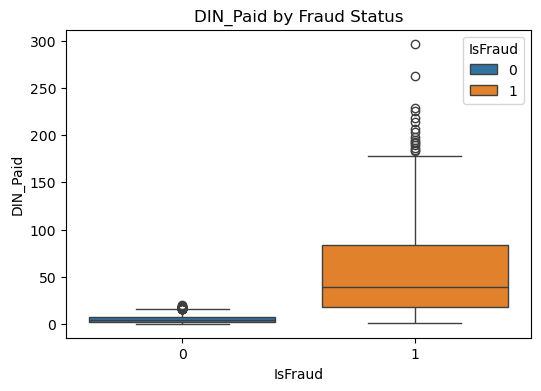




Summary statistics of DispenseFee_Submitted by IsFraud:
          count       mean       std       min       25%        50%  \
IsFraud                                                               
0        7764.0  11.519378  2.023824  8.001097  9.790528  11.550868   
1         420.0  11.564451  2.044667  8.016459  9.821171  11.529510   

               75%        max  
IsFraud                        
0        13.280109  14.999850  
1        13.371583  14.981033  


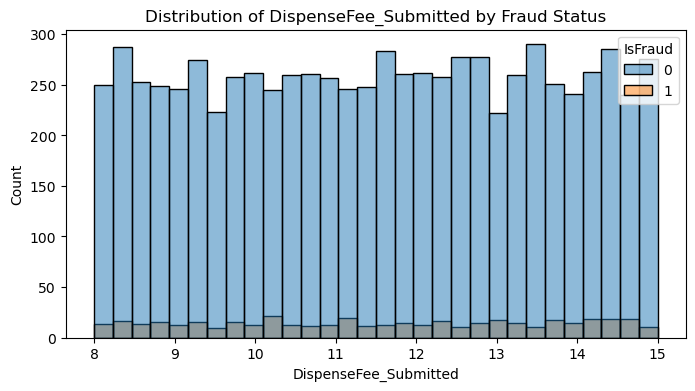

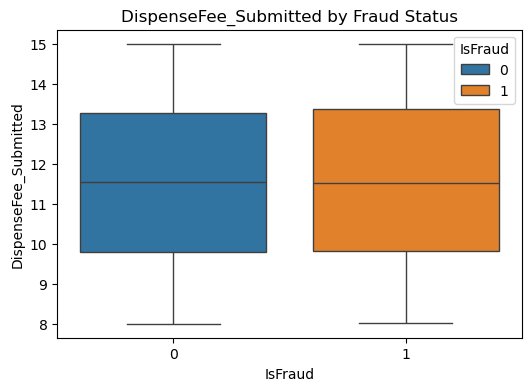




Summary statistics of DispenseFee_Paid by IsFraud:
          count       mean       std       min       25%        50%  \
IsFraud                                                               
0        7764.0  11.519378  2.023824  8.001097  9.790528  11.550868   
1         420.0  11.564451  2.044667  8.016459  9.821171  11.529510   

               75%        max  
IsFraud                        
0        13.280109  14.999850  
1        13.371583  14.981033  


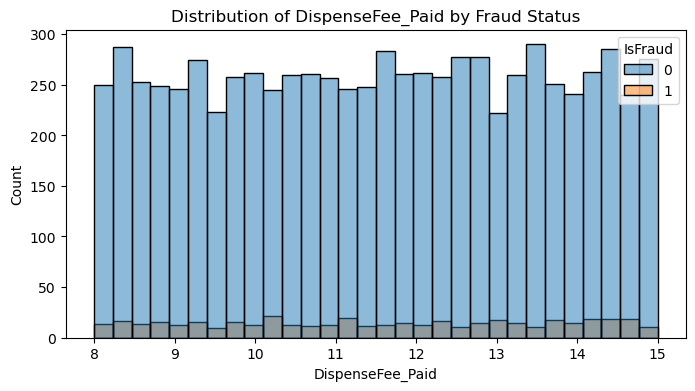

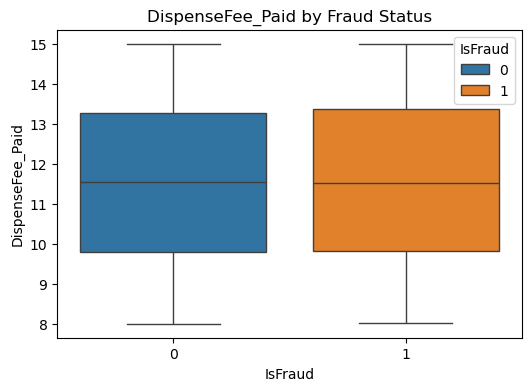




Summary statistics of TotalPaid by IsFraud:
          count       mean        std        min        25%        50%  \
IsFraud                                                                  
0        7764.0  16.804300   4.417623   8.253799  13.598877  16.088323   
1         420.0  69.682202  53.824675  10.510912  28.995333  50.820813   

               75%         max  
IsFraud                         
0        19.566619   32.158736  
1        94.823564  310.470357  


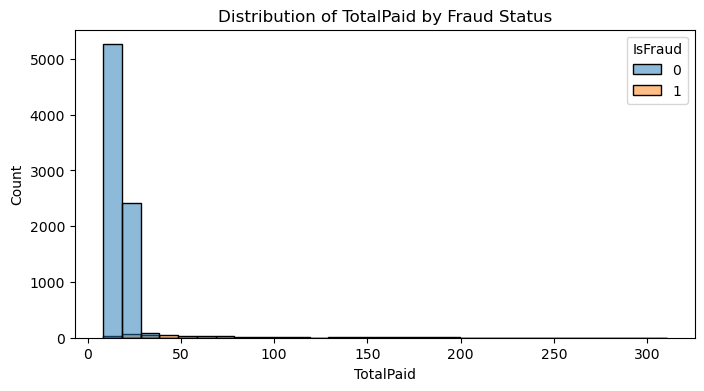

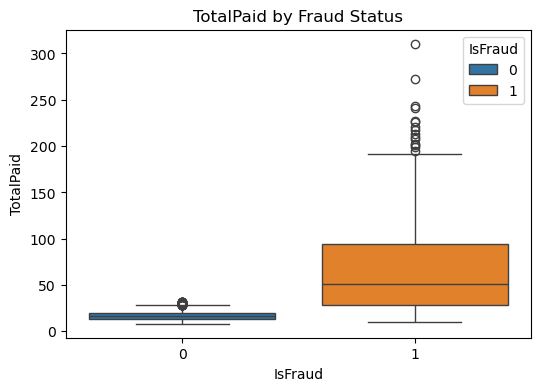




Summary statistics of pack_unit by IsFraud:
          count      mean      std       min       25%       50%       75%  \
IsFraud                                                                      
0        7764.0  0.055492  0.02590  0.009377  0.033799  0.055630  0.077014   
1         420.0  0.623325  0.42383  0.030608  0.267407  0.528151  0.895581   

              max  
IsFraud            
0        0.109350  
1        2.097691  


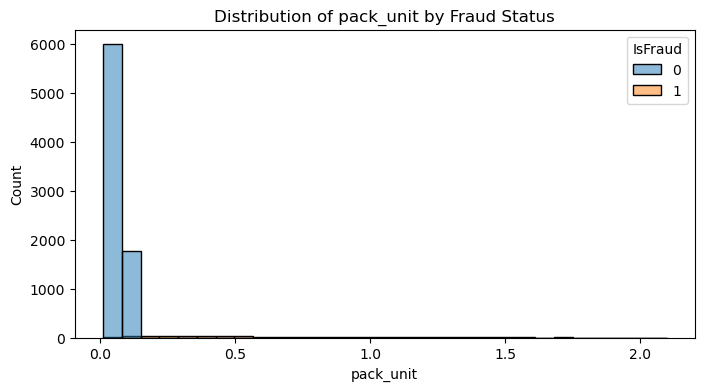

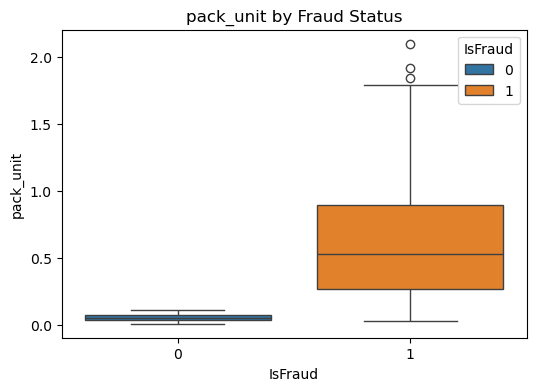




Value counts for PharmacyName by Fraud Status:
IsFraud  PharmacyName          
0        WellPharm City            439
         HealthRx Prime            418
         PharmaCare Downtown       418
         PharmaCare Central        412
         MediPlus Center           408
         MediPlus Health           404
         CarePharmacy Direct       402
         MediPlus Community        402
         CarePharmacy First        396
         WellPharm Care            395
         PharmaCare Express        386
         HealthRx Complete         381
         HealthRx Main             379
         HealthRx Professional     379
         WellPharm Total           379
         PharmaCare Plus           376
         CarePharmacy Pro          364
         CarePharmacy Essential    355
         WellPharm Wellness        343
         MediPlus Family           328
1        HealthRx Main              28
         MediPlus Community         27
         WellPharm Total            26
         CarePharmacy

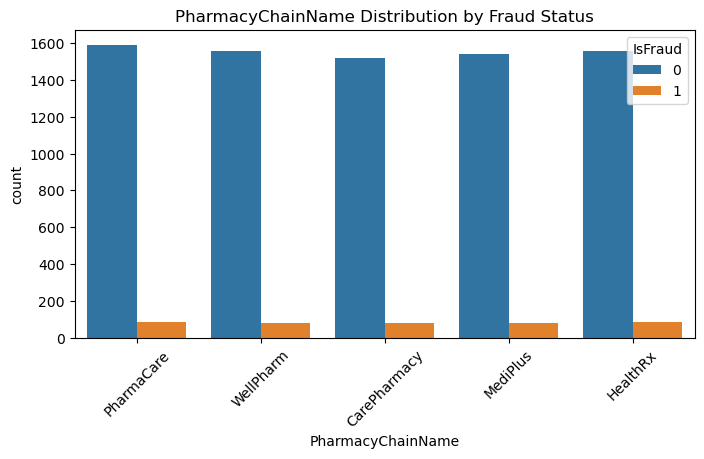




Value counts for City by Fraud Status:
IsFraud  City       
0        Montreal       1029
         Ottawa         1004
         Edmonton        998
         Winnipeg        972
         Quebec City     957
         Toronto         950
         Calgary         946
         Vancouver       908
1        Toronto          58
         Vancouver        57
         Ottawa           56
         Quebec City      55
         Montreal         51
         Calgary          49
         Edmonton         48
         Winnipeg         46
Name: count, dtype: int64
IsFraud  City       
0        Montreal       0.132535
         Ottawa         0.129315
         Edmonton       0.128542
         Winnipeg       0.125193
         Quebec City    0.123261
         Toronto        0.122360
         Calgary        0.121844
         Vancouver      0.116950
1        Toronto        0.138095
         Vancouver      0.135714
         Ottawa         0.133333
         Quebec City    0.130952
         Montreal       0.1214

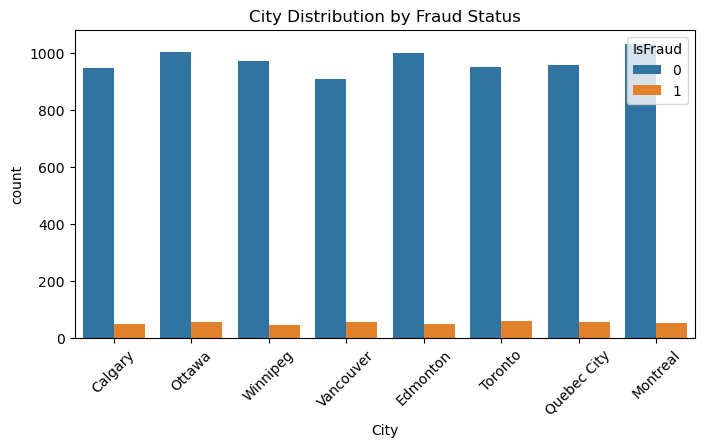




Value counts for Province by Fraud Status:
IsFraud  Province
0        QC          1986
         ON          1954
         AB          1944
         MB           972
         BC           908
1        ON           114
         QC           106
         AB            97
         BC            57
         MB            46
Name: count, dtype: int64
IsFraud  Province
0        QC          0.255796
         ON          0.251674
         AB          0.250386
         MB          0.125193
         BC          0.116950
1        ON          0.271429
         QC          0.252381
         AB          0.230952
         BC          0.135714
         MB          0.109524
Name: proportion, dtype: float64


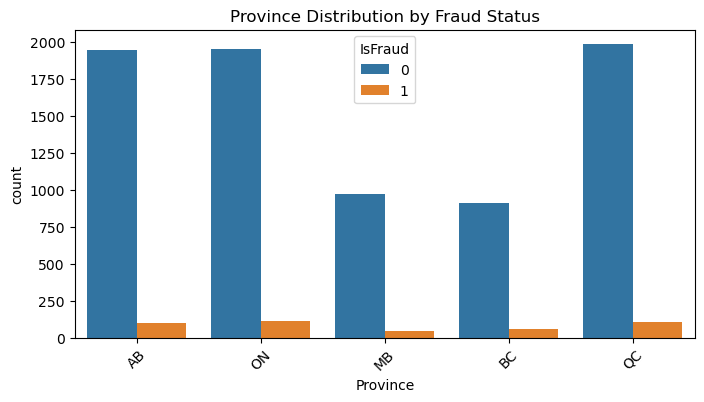




Value counts for Postcode by Fraud Status:
IsFraud  Postcode
0        K1P 5G3     281
         H2Y 1Z8     277
         H3A 1A9     273
         T6C 4N9     267
         R3M 2L7     263
                    ... 
1        K1P 5G3       8
         T2G 5R7       7
         T5J 2R4       7
         T2P 1J9       6
         R3C 0V1       4
Name: count, Length: 64, dtype: int64
IsFraud  Postcode
0        K1P 5G3     0.036193
         H2Y 1Z8     0.035677
         H3A 1A9     0.035162
         T6C 4N9     0.034389
         R3M 2L7     0.033874
                       ...   
1        K1P 5G3     0.019048
         T2G 5R7     0.016667
         T5J 2R4     0.016667
         T2P 1J9     0.014286
         R3C 0V1     0.009524
Name: proportion, Length: 64, dtype: float64



Value counts for TherapyClass by Fraud Status:
IsFraud  TherapyClass        
0        Hormonal                844
         Antiinflammatories      812
         Gastrointestinal        811
         Cholesterol Reducers    792
  

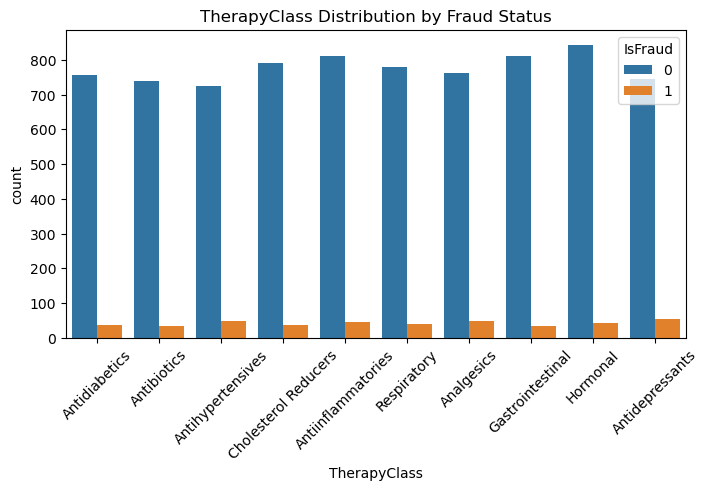

In [15]:
# use the eda_by_fraud function with ClaimID, ClaimantID, and DIN
eda_by_fraud(complete_data.drop(['DIN', 'ClaimID', 'ClaimantID'], axis = 1))

The correlation matrix for the numerical features were created, as shown below. Features like DIN Submitted, DIN Paid, Total Paid, and PackUnit were strongly associated with fraud. Given that DIN submitted is highly correlated with DIN paid AND is used directly in the pack unit formula, we decided to exclude it in our models.

<Axes: >

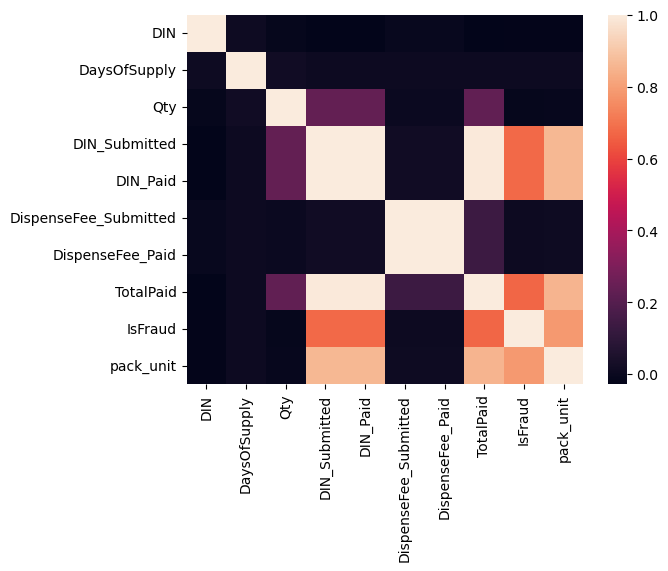

In [16]:
# Correlation plot to view the correlation between numeric variables
sns.heatmap(complete_data.corr(numeric_only=True))

# **Interesting variables based on EDA Results**

Therefore, based on our EDA and correlation findings, the five strongest fraud indicators were pack unit, total paid, DIN paid, province, and therapy class.

* pack_unit

* TotalPaid

* DIN_Paid

* Province

* Therapyclass


# **Plan for Models**
One model with select variables

# **Type of Models**

Baseline: Logistic

Experiments (Models to test as they can deal with multicollinearity):
1.   Random Forest
2.   ADA boost
3.   Decision Tree (Unpruned & Pruned)
4.   K nearest
5.   Xgboost

For each model, check the accuracy of each fold using k-fold cross validation(10 splits). Also check the mean and standard devation of all results. When using the model for predictions check the true poistive, false positive, true negative, and false negative rates. Also put these together in a confusion matrix. Finally, check the area under the curve (AUC) and generate a receiver operator curve (ROC) plot.

## **Feature Engineering**

In [17]:
# Dataframe with select variables
df_select = complete_data[['pack_unit', 'TotalPaid', 'DIN_Paid', 'Province', 'TherapyClass', 'IsFraud']].reset_index(drop = True)
print(df_select.head())

# Factor categorical variables
le = LabelEncoder()
df_select['Province'] = le.fit_transform(df_select['Province'])
df_select['TherapyClass'] = le.fit_transform(df_select['TherapyClass'])
print(df_select.head())

   pack_unit  TotalPaid  DIN_Paid Province       TherapyClass  IsFraud
0   0.047668  12.487163  3.765769       AB      Antidiabetics        0
1   0.027149  11.570808  1.357430       ON        Antibiotics        0
2   0.067448  18.727791  6.137803       MB  Antihypertensives        0
3   0.020936  11.966593  1.716781       ON      Antidiabetics        0
4   0.047330  21.864432  7.004796       AB  Antihypertensives        0
   pack_unit  TotalPaid  DIN_Paid  Province  TherapyClass  IsFraud
0   0.047668  12.487163  3.765769         0             3        0
1   0.027149  11.570808  1.357430         3             1        0
2   0.067448  18.727791  6.137803         2             4        0
3   0.020936  11.966593  1.716781         3             3        0
4   0.047330  21.864432  7.004796         0             4        0


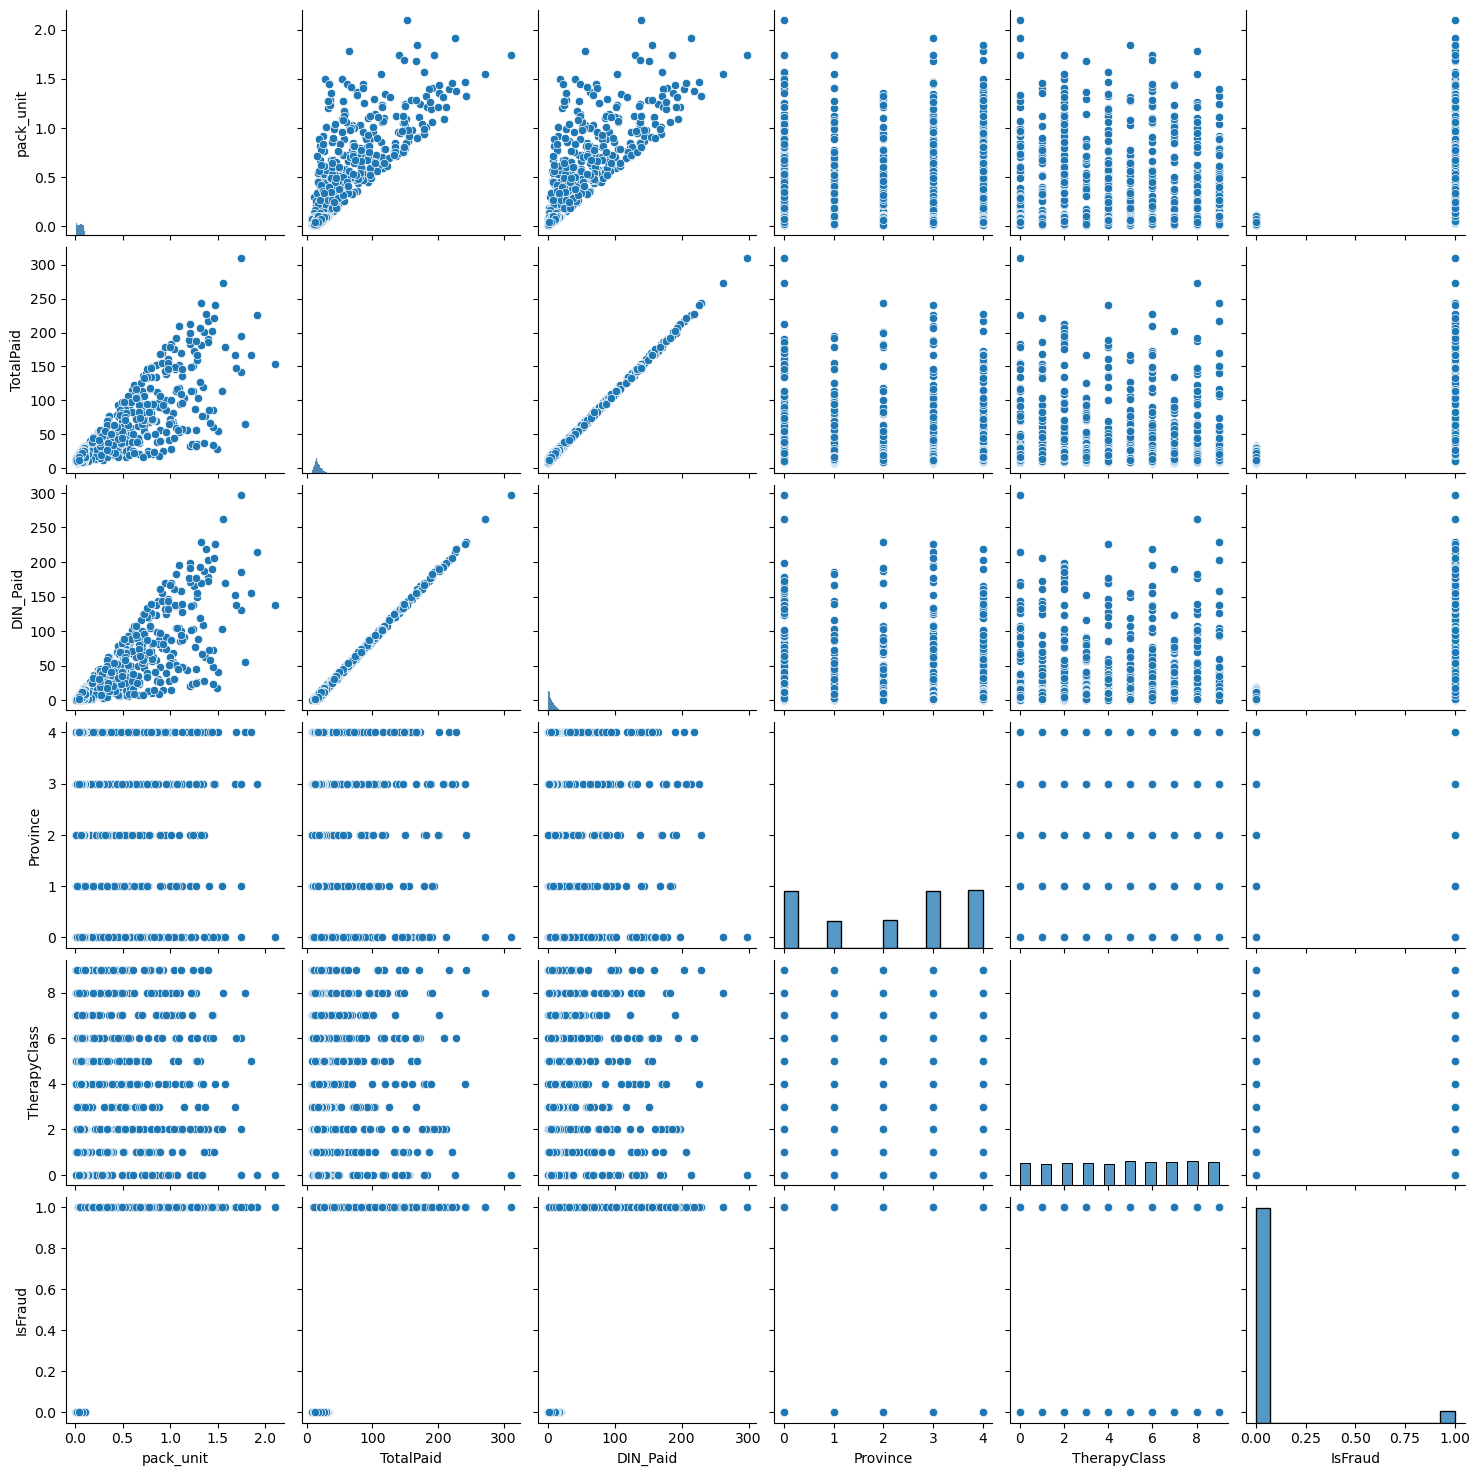

In [18]:
# view the data together with a pairplot
sns.pairplot(df_select)

### **Split Data into Train and Test for Following Models**
The split will be completed by stratifying the IsFraud column.

In [19]:
X = df_select.drop('IsFraud', axis = 1)
y = df_select['IsFraud']

# Split data into train and test
# Stratify split with IsFraud
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)

# Check distribution of IsFraud status between train and test
print('Distribution of Fraud Status in Training Set:')
print('\n', y_train.value_counts())
print('\n', y_train.value_counts() / y_train.shape[0])
print('\nDistribution of Fraud Status in Test Set:')
print('\n', y_test.value_counts())
print('\n', y_test.value_counts() / y_test.shape[0])

Distribution of Fraud Status in Training Set:

 IsFraud
0    6211
1     336
Name: count, dtype: int64

 IsFraud
0    0.948679
1    0.051321
Name: count, dtype: float64

Distribution of Fraud Status in Test Set:

 IsFraud
0    1553
1      84
Name: count, dtype: int64

 IsFraud
0    0.948687
1    0.051313
Name: count, dtype: float64


## **Logistic Regression**

In [20]:
# Define a function for plotting the confusion matrix
dict_characters = {0: 'Not Fraud', 1: 'Fraud'}
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [21]:
# fit the model
X = df_select.drop('IsFraud', axis = 1)
y = df_select['IsFraud']
lr = LogisticRegression()
model_lr = lr.fit(X, y)

# use k fold cross validation
kfold = model_selection.KFold(n_splits = 10)
accuracy_results_lr = model_selection.cross_val_score(model_lr, X, y,
                                                   cv = kfold, scoring ='accuracy')
# check the accuracy
print(accuracy_results_lr)
print(accuracy_results_lr.mean(), accuracy_results_lr.std())
# High accuracy results - maybe due to skewed distribution of Fraudulent vs non-Fraudulent claims

[0.99389499 0.98778999 0.98901099 0.98046398 0.99022005 0.98899756
 0.98655257 0.98533007 0.99266504 0.99266504]
0.9887590269008362 0.0038147079365504293


In [22]:
# Predict on test data
# check the false positives, false negatives, true positives, and true negatives when predicting (all models)
y_pred_lr = model_lr.predict(X_test)
tn_lr, fp_lr, fn_lr, tp_lr = confusion_matrix(y_test, y_pred_lr).ravel()

print(f"True Positives (TP): {tp_lr}")
print(f"True Negatives (TN): {tn_lr}")
print(f"False Positives (FP): {fp_lr}")
print(f"False Negatives (FN): {fn_lr}")

True Positives (TP): 74
True Negatives (TN): 1553
False Positives (FP): 0
False Negatives (FN): 10


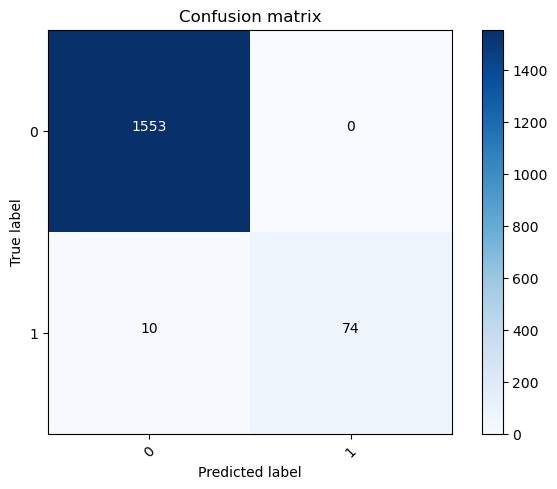

In [23]:
# Plot the confusion matrix
cnf_matrix_lr = confusion_matrix(y_test, y_pred_lr)

plot_confusion_matrix(cnf_matrix_lr, classes = dict_characters,title='Confusion matrix')
plt.show()

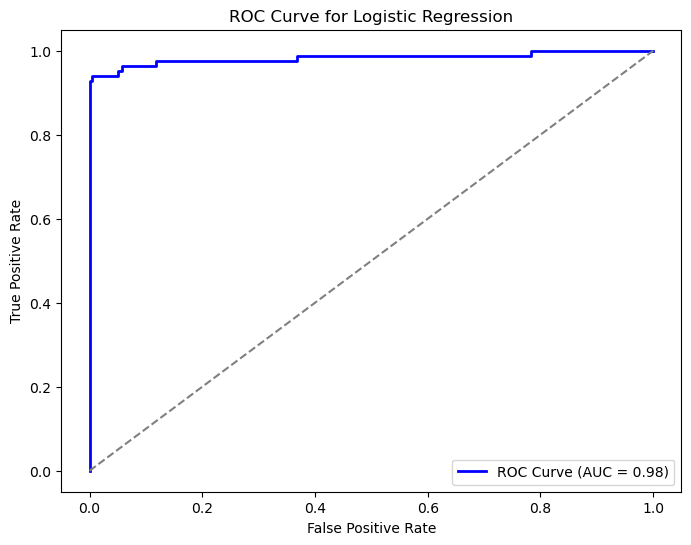

In [24]:
y_probs_lr = model_lr.predict_proba(X_test)[:, 1]
# Compute ROC curve
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_probs_lr)

# Compute AUC (Area Under Curve)
roc_auc_lr = auc(fpr_lr, tpr_lr)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_lr, tpr_lr, color='blue', lw = 2, label = f'ROC Curve (AUC = {roc_auc_lr:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Random classifier line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Logistic Regression')
plt.legend(loc='lower right')
plt.show()

Results are not reliable because logistic regression relies on the assumption of normality, which is not present in our data. Therefore, we decided to test other models that can handle multicollinearity.

## **Random Forest**

In [25]:
# create a random forest classifier
rf = RandomForestClassifier()
model_rf = rf.fit(X_train, y_train)

kfold = model_selection.KFold(n_splits=10)
accuracy_results_rf = model_selection.cross_val_score(model_rf, X_train, y_train,
                                                   cv = kfold, scoring = 'accuracy')

# check the accuracy for each fold and the mean and std for all the fold together
print(accuracy_results_rf)
print(accuracy_results_rf.mean(), accuracy_results_rf.std()) # Higher than logistic

[0.99694656 0.99694656 0.99541985 0.99389313 0.99847328 0.99847328
 0.99541985 0.99541284 0.9969419  0.99082569]
0.9958752947218527 0.0021676759156079657


In [26]:
# Predict on test data
y_pred_rf = model_rf.predict(X_test)
tn_rf, fp_rf, fn_rf, tp_rf = confusion_matrix(y_test, y_pred_rf).ravel()

print(f"True Positives (TP): {tp_rf}")
print(f"True Negatives (TN): {tn_rf}")
print(f"False Positives (FP): {fp_rf}")
print(f"False Negatives (FN): {fn_rf}")

True Positives (TP): 83
True Negatives (TN): 1553
False Positives (FP): 0
False Negatives (FN): 1


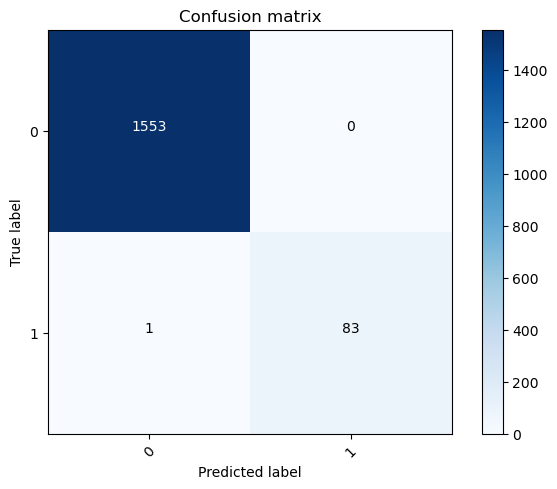

In [27]:
# Plot the confusion matrix
cnf_matrix_rf = confusion_matrix(y_test, y_pred_rf)

plot_confusion_matrix(cnf_matrix_rf, classes = dict_characters,title='Confusion matrix')
plt.show()

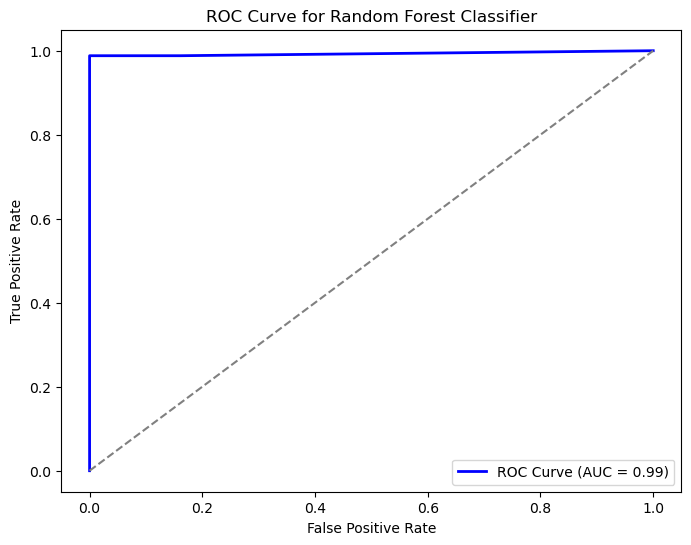

In [28]:
y_probs_rf = model_rf.predict_proba(X_test)[:, 1]
# Compute ROC curve
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_probs_rf)

# Compute AUC (Area Under Curve)
roc_auc_rf = auc(fpr_rf, tpr_rf)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, color='blue', lw = 2, label = f'ROC Curve (AUC = {roc_auc_rf:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Random classifier line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Random Forest Classifier')
plt.legend(loc='lower right')
plt.show()

In [29]:
# Checking feature importance for this model

columns = X.columns
coefficients = model_rf.feature_importances_.reshape(X.columns.shape[0], 1)
absCoefficients = abs(coefficients)
fullList = pd.concat((pd.DataFrame(columns, columns = ['Variable']), pd.DataFrame(absCoefficients, columns = ['absCoefficient'])), axis = 1).sort_values(by='absCoefficient', ascending = False)
print('RandomForestClassifier - Feature Importance:')
print('\n',fullList,'\n')

RandomForestClassifier - Feature Importance:

        Variable  absCoefficient
0     pack_unit        0.522692
2      DIN_Paid        0.286309
1     TotalPaid        0.183776
4  TherapyClass        0.004745
3      Province        0.002478 



Pack unit was found to be the most important feature out of the six selected features, based on Random Forest Classifier. In contrast, therapy class and province were found to be the least important features, with coefficients less than 0.0001. This indicates that they do not act as significant predictors for detecting fraudulent claims, similar to what was found in our EDA.

## **ADA Boost Classifier**

In [30]:
# define an ADA boost classifier
ab = AdaBoostClassifier()
model_ab = ab.fit(X_train, y_train)

kfold = model_selection.KFold(n_splits=10)
accuracy_results_ab = model_selection.cross_val_score(model_ab, X_train, y_train,
                                                   cv = kfold, scoring = 'accuracy')

print(accuracy_results_ab)
print(accuracy_results_ab.mean(), accuracy_results_ab.std())

/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/ana

[0.99694656 0.99694656 0.99541985 0.99389313 0.99694656 0.99847328
 0.99694656 0.99388379 0.9969419  0.99082569]
0.9957223895230758 0.002141141705113294


/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


True Positives (TP): 83
True Negatives (TN): 1553
False Positives (FP): 0
False Negatives (FN): 1


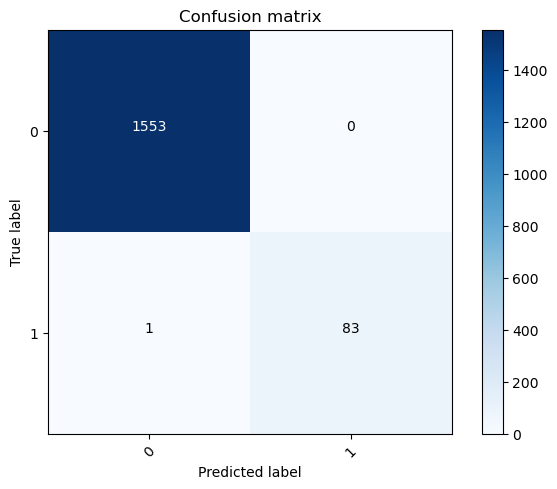

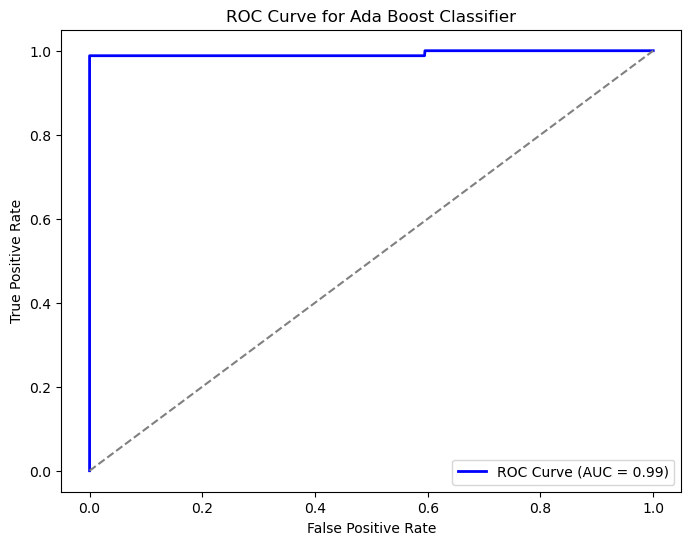

Ada Boost Classifier - Feature Importance:

        Variable  absCoefficient
0     pack_unit            0.48
2      DIN_Paid            0.32
1     TotalPaid            0.10
4  TherapyClass            0.08
3      Province            0.02 



In [31]:
# Predict on test data
y_pred_ab = model_ab.predict(X_test)
tn_ab, fp_ab, fn_ab, tp_ab = confusion_matrix(y_test, y_pred_ab).ravel()

print(f"True Positives (TP): {tp_ab}")
print(f"True Negatives (TN): {tn_ab}")
print(f"False Positives (FP): {fp_ab}")
print(f"False Negatives (FN): {fn_ab}")

y_probs_ab = model_ab.predict_proba(X_test)[:, 1]

# Plot Confusion Matrix
cnf_matrix_ab = confusion_matrix(y_test, y_pred_ab)

plot_confusion_matrix(cnf_matrix_ab, classes = dict_characters,title='Confusion matrix')
plt.show()


# Compute ROC curve
fpr_ab, tpr_ab, _ = roc_curve(y_test, y_probs_ab)

# Compute AUC (Area Under Curve)
roc_auc_ab = auc(fpr_ab, tpr_ab)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_ab, tpr_ab, color='blue', lw = 2, label = f'ROC Curve (AUC = {roc_auc_ab:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Ada Boost Classifier')
plt.legend(loc='lower right')
plt.show()

# Checking feature importance for this model

coefficients = model_ab.feature_importances_.reshape(X.columns.shape[0], 1)
absCoefficients = abs(coefficients)
fullList = pd.concat((pd.DataFrame(columns, columns = ['Variable']), pd.DataFrame(absCoefficients, columns = ['absCoefficient'])), axis = 1).sort_values(by='absCoefficient', ascending = False)
print('Ada Boost Classifier - Feature Importance:')
print('\n',fullList,'\n')

Pack unit was found to be the most important feature out of the six selected features, based on Ada Boost Classifier. However, in contrast to the Random Forest Classifier, the feature importance of therapy class increased, while that of total paid dropped to 0. This can be attributed to Adaboost's classification algorithm that has a sequential learning architecture, as opposed to Random Forest's ensemble learning that considers all trees in parallel.

## **Decision Tree**

In [32]:
# define a function to run the decision tree
def runDecisionTree(a, b, c, d, max_depth = 50):
    model = DecisionTreeClassifier(max_depth = max_depth)
    accuracy_scorer = make_scorer(accuracy_score)
    model.fit(a, b)
    kfold = model_selection.KFold(n_splits=10, shuffle=True)
    accuracy = model_selection.cross_val_score(model, a, b, cv=kfold, scoring='accuracy')
    mean = accuracy.mean()
    stdev = accuracy.std()
    prediction = model.predict(c)
    cnf_matrix = confusion_matrix(d, prediction)


    plot_confusion_matrix(cnf_matrix, classes = dict_characters,title='Confusion matrix')
    plt.show()
    print('DecisionTreeClassifier - Training set accuracy: %s (%s)' % (mean, stdev))
    return model

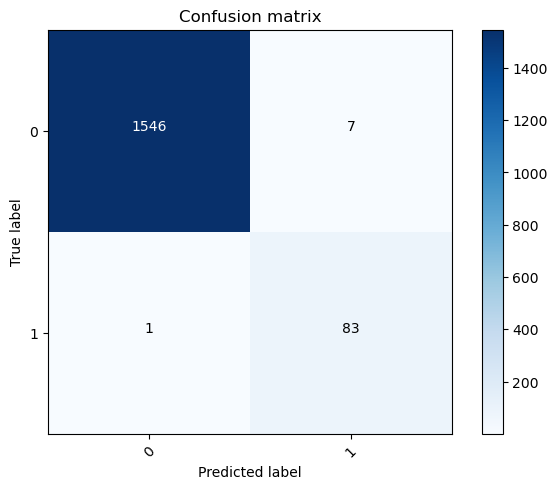

DecisionTreeClassifier - Training set accuracy: 0.9917522235450662 (0.002913776368206932)


In [33]:
# define the decision tree with the previously created function
model_dt = runDecisionTree(X_train, y_train, X_test, y_test)

True Positives (TP): 83
True Negatives (TN): 1546
False Positives (FP): 7
False Negatives (FN): 1


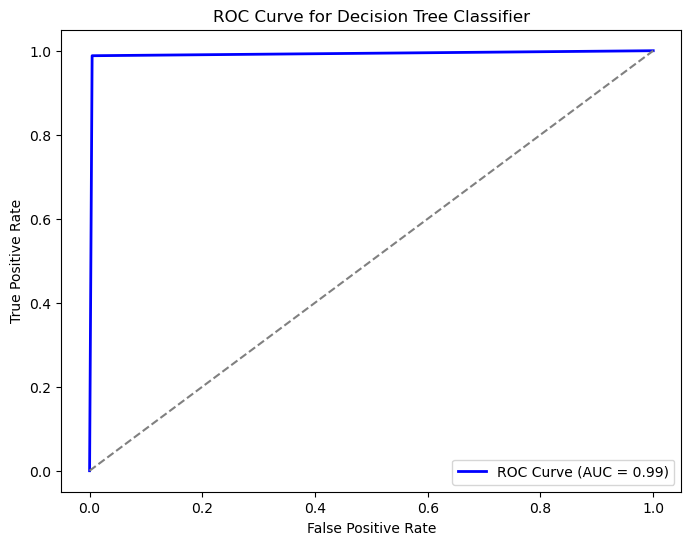

Decision Tree Classifier - Feature Importance:

        Variable  absCoefficient
0     pack_unit        0.953420
2      DIN_Paid        0.022121
1     TotalPaid        0.021254
4  TherapyClass        0.003089
3      Province        0.000116 



In [34]:
# Predict on test data
y_pred_dt = model_dt.predict(X_test)
tn_dt, fp_dt, fn_dt, tp_dt = confusion_matrix(y_test, y_pred_dt).ravel()

print(f"True Positives (TP): {tp_dt}")
print(f"True Negatives (TN): {tn_dt}")
print(f"False Positives (FP): {fp_dt}")
print(f"False Negatives (FN): {fn_dt}")

y_probs_dt = model_dt.predict_proba(X_test)[:, 1]
# Compute ROC curve
fpr_dt, tpr_dt, _ = roc_curve(y_test, y_probs_dt)

# Compute AUC (Area Under Curve)
roc_auc_dt = auc(fpr_dt, tpr_dt)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_dt, tpr_dt, color='blue', lw = 2, label = f'ROC Curve (AUC = {roc_auc_dt:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Decision Tree Classifier')
plt.legend(loc='lower right')
plt.show()

# Checking feature importance for this model

coefficients = model_dt.feature_importances_.reshape(X.columns.shape[0], 1)
absCoefficients = abs(coefficients)
fullList = pd.concat((pd.DataFrame(columns, columns = ['Variable']), pd.DataFrame(absCoefficients, columns = ['absCoefficient'])), axis = 1).sort_values(by='absCoefficient', ascending = False)
print('Decision Tree Classifier - Feature Importance:')
print('\n',fullList,'\n')

Pack unit is the most important feature with a high absolute coefficient of 0.95. This indicates that pack unit has a very high predictive power, with almost all claims were identified based on their calculated pack unit. All other variables had minimal contribution to the classification, which reinforces the fact that pack unit is a key feature in distinguishing fraudulent activity.

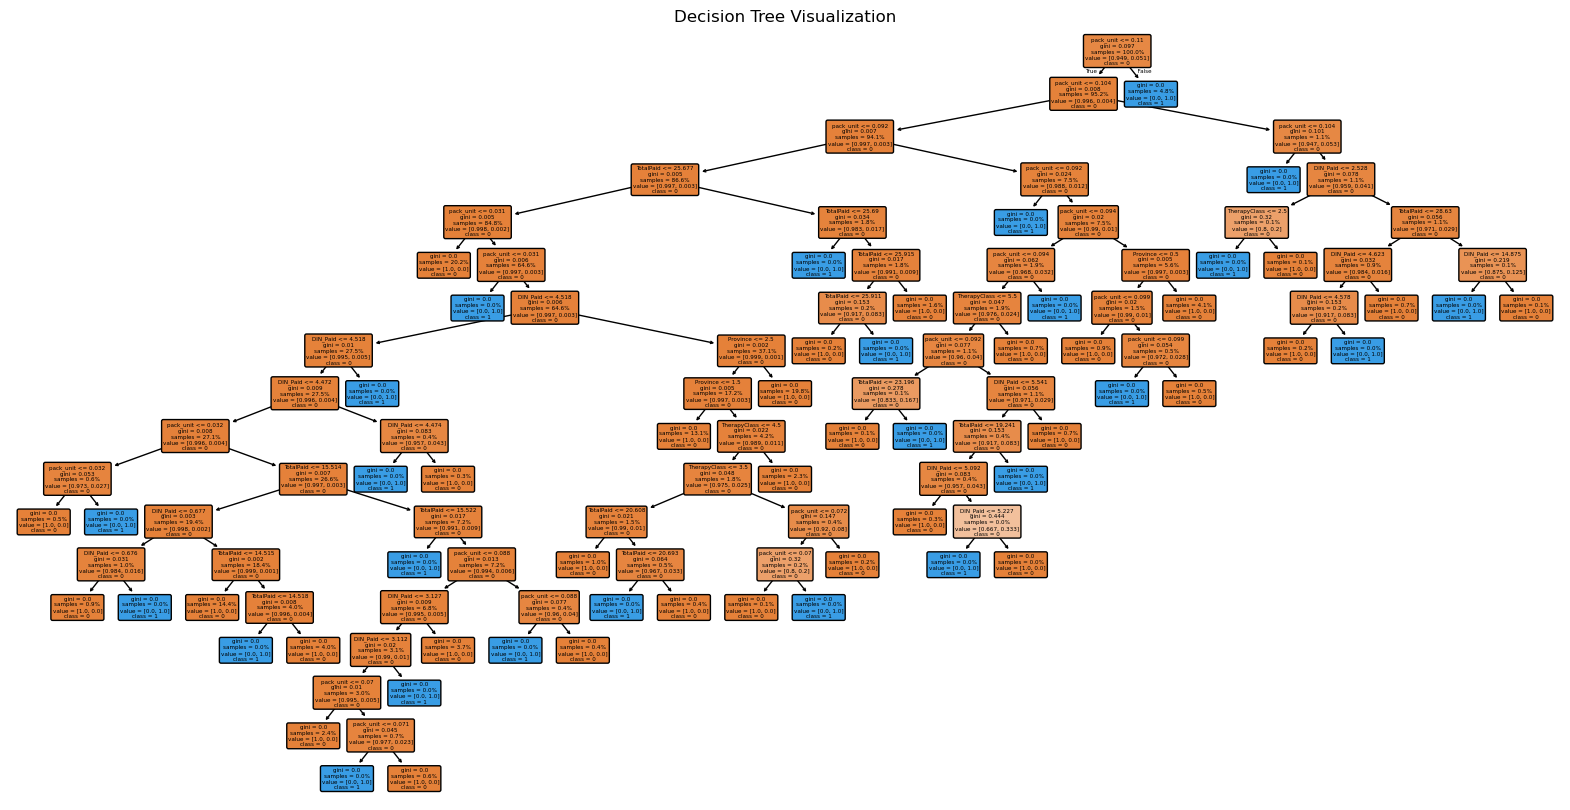

In [35]:
# Plot the decision tree
plt.figure(figsize=(20,10))  # Adjust size as needed
plot_tree(model_dt,
          filled=True,
          feature_names=X_train.columns if hasattr(X_train, 'columns') else None,
          class_names=[str(c) for c in model_dt.classes_],
          rounded=True,
          proportion=True)
plt.title("Decision Tree Visualization")
plt.show()

### **Pruned Tree**
Using a depth of 1, as indicated by the unpruned decision tree (the first step appears to be the most important, as seen in the above diagram)


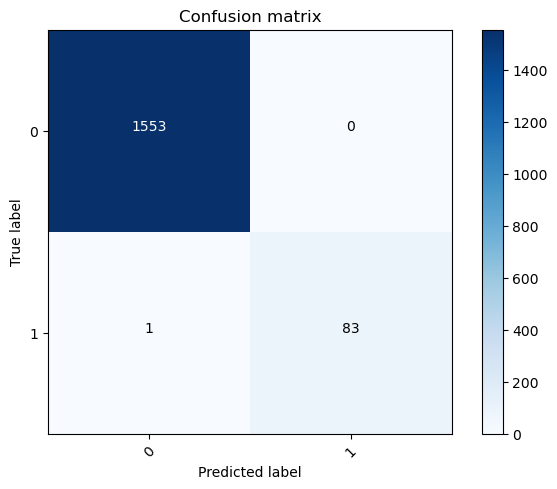

DecisionTreeClassifier - Training set accuracy: 0.9960286668067326 (0.001700754250631488)
True Positives (TP): 83
True Negatives (TN): 1553
False Positives (FP): 0
False Negatives (FN): 1


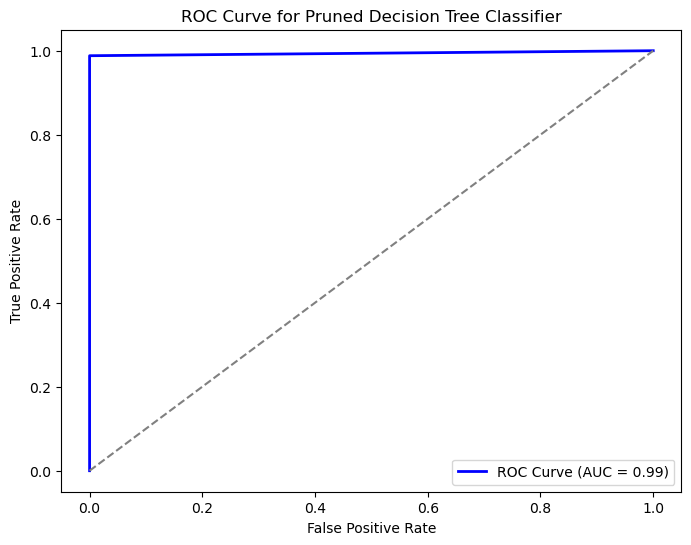

Pruned Decision Tree Classifier - Feature Importance:

        Variable  absCoefficient
0     pack_unit             1.0
1     TotalPaid             0.0
2      DIN_Paid             0.0
3      Province             0.0
4  TherapyClass             0.0 



In [36]:
# using the decision tree function, define the prune tree
model_dt_pruned = runDecisionTree(X_train, y_train, X_test, y_test, max_depth = 1)
# Predict on test data
y_pred_dt_pruned = model_dt_pruned.predict(X_test)
tn_dt_pruned, fp_dt_pruned, fn_dt_pruned, tp_dt_pruned = confusion_matrix(y_test, y_pred_dt_pruned).ravel()

print(f"True Positives (TP): {tp_dt_pruned}")
print(f"True Negatives (TN): {tn_dt_pruned}")
print(f"False Positives (FP): {fp_dt_pruned}")
print(f"False Negatives (FN): {fn_dt_pruned}")

y_probs_dt_pruned = model_dt_pruned.predict_proba(X_test)[:, 1]
# Compute ROC curve
fpr_dt_pruned, tpr_dt_pruned, _ = roc_curve(y_test, y_probs_dt_pruned)

# Compute AUC (Area Under Curve)
roc_auc_dt_pruned = auc(fpr_dt_pruned, tpr_dt_pruned)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_dt_pruned, tpr_dt_pruned, color='blue', lw = 2, label = f'ROC Curve (AUC = {roc_auc_dt_pruned:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Pruned Decision Tree Classifier')
plt.legend(loc='lower right')
plt.show()

# Checking feature importance for this model

coefficients = model_dt_pruned.feature_importances_.reshape(X.columns.shape[0], 1)
absCoefficients = abs(coefficients)
fullList = pd.concat((pd.DataFrame(columns, columns = ['Variable']), pd.DataFrame(absCoefficients, columns = ['absCoefficient'])), axis = 1).sort_values(by='absCoefficient', ascending = False)
print('Pruned Decision Tree Classifier - Feature Importance:')
print('\n',fullList,'\n')

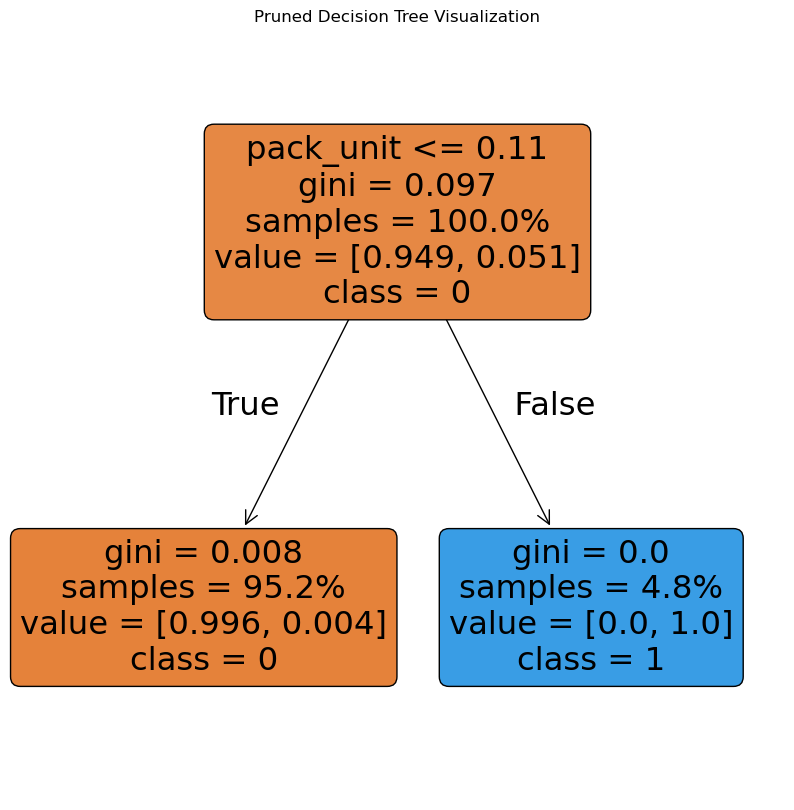

In [37]:
# Plot the decision tree
plt.figure(figsize=(10, 10))  # Adjust size as needed
plot_tree(model_dt_pruned,
          filled=True,
          feature_names=X_train.columns if hasattr(X_train, 'columns') else None,
          class_names=[str(c) for c in model_dt.classes_],
          rounded=True,
          proportion=True)
plt.title("Pruned Decision Tree Visualization")
plt.show()

Pack unit is the only feature that is used in this pruned decision tree. All other features are not relied on for classification. Despite it having a depth of 1, as known as a decision stump, it performed better than the unpruned tree. A tree with a depth of 5 was also tested, which the decision stump still outperformed.

## **K nearest neighbours**

In [38]:
# scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the dataset into training and testing sets
X_train2, X_test2, y_train2, y_test2 = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42)

# Initialize and train the classifier
model_knn = KNeighborsClassifier(n_neighbors=5)
model_knn.fit(X_train2, y_train2)

# 10-fold cross-validation
kfold = KFold(n_splits=10)
accuracy_results_knn = cross_val_score(model_knn, X_train2, y_train2,
                                       cv = kfold, scoring = 'accuracy')

# Print cross-validation accuracy
print(accuracy_results_knn)
print(f"Mean Accuracy: {accuracy_results_knn.mean():.4f}")
print(f"Standard Deviation: {accuracy_results_knn.std():.4f}")

[0.99236641 0.99236641 0.99083969 0.99389313 0.98931298 0.99694656
 0.99236641 0.98929664 0.99082569 0.99388379]
Mean Accuracy: 0.9922
Standard Deviation: 0.0022


True Positives (TP): 85
True Negatives (TN): 1538
False Positives (FP): 0
False Negatives (FN): 14


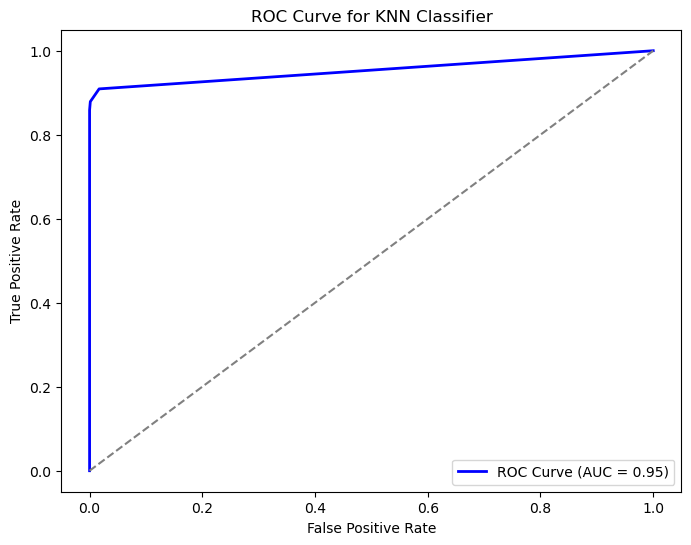

Accuracy: 0.99

Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00      1538
           1       1.00      0.86      0.92        99

    accuracy                           0.99      1637
   macro avg       1.00      0.93      0.96      1637
weighted avg       0.99      0.99      0.99      1637


Confusion Matrix:
 [[1538    0]
 [  14   85]]


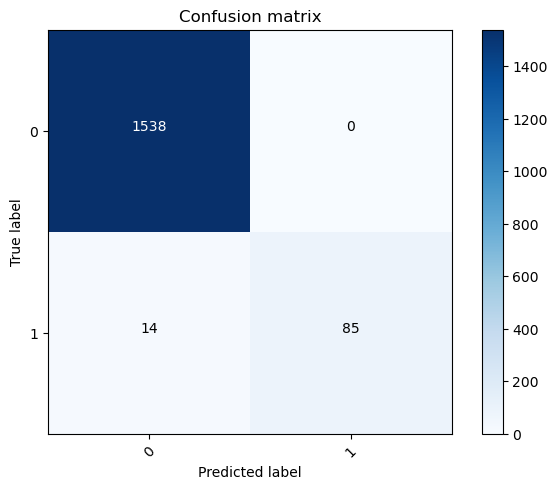

In [39]:
# Predict on test data
y_pred_knn = model_knn.predict(X_test2)
tn_knn, fp_knn, fn_knn, tp_knn = confusion_matrix(y_test2, y_pred_knn).ravel()

print(f"True Positives (TP): {tp_knn}")
print(f"True Negatives (TN): {tn_knn}")
print(f"False Positives (FP): {fp_knn}")
print(f"False Negatives (FN): {fn_knn}")

# Predict probabilities for ROC
y_probs_knn = model_knn.predict_proba(X_test2)[:, 1]

# Compute ROC curve
fpr_knn, tpr_knn, _ = roc_curve(y_test2, y_probs_knn)
roc_auc_knn = auc(fpr_knn, tpr_knn)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_knn, tpr_knn, color = 'blue', lw=2, label=f'ROC Curve (AUC = {roc_auc_knn:.2f})')
plt.plot([0, 1], [0, 1], color = 'gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for KNN Classifier')
plt.legend(loc='lower right')
plt.show()

# Evaluate
accuracy = accuracy_score(y_test2, y_pred_knn)
print(f'Accuracy: {accuracy:.2f}')
print('\nClassification Report:\n', classification_report(y_test2, y_pred_knn))
print('\nConfusion Matrix:\n', confusion_matrix(y_test2, y_pred_knn))

# Plot Confusion Matrix
cnf_matrix_knn = confusion_matrix(y_test2, y_pred_knn)

plot_confusion_matrix(cnf_matrix_knn, classes = dict_characters,title='Confusion matrix')
plt.show()


## **Xgboost**

In [40]:
# Initialize the XGBoost Classifier
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Fit the model
model_xgb = xgb.fit(X_train, y_train)

# 10-fold cross-validation
kfold = KFold(n_splits=10)
accuracy_results_xgb = cross_val_score(model_xgb, X_train, y_train,
                                       cv = kfold, scoring = 'accuracy')

# Print cross-validation accuracy
print(accuracy_results_xgb)
print(f"Mean Accuracy: {accuracy_results_xgb.mean():.4f}")
print(f"Standard Deviation: {accuracy_results_xgb.std():.4f}")

/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [04:28:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [04:28:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [04:28:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [04:28:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

[0.99389313 0.99541985 0.99389313 0.99389313 0.99541985 0.99847328
 0.99541985 0.99388379 0.99541284 0.98776758]
Mean Accuracy: 0.9943
Standard Deviation: 0.0026


True Positives (TP): 82
True Negatives (TN): 1550
False Positives (FP): 3
False Negatives (FN): 2


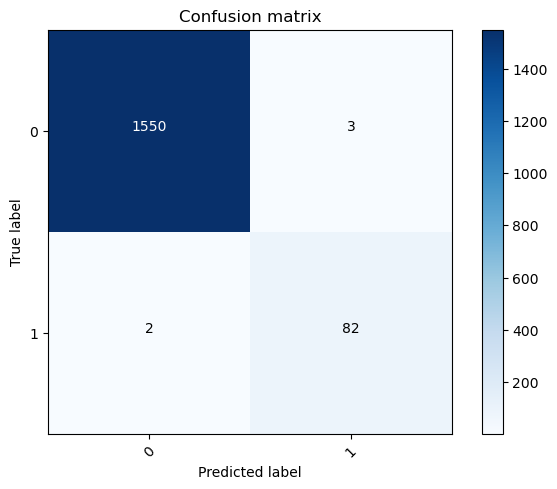

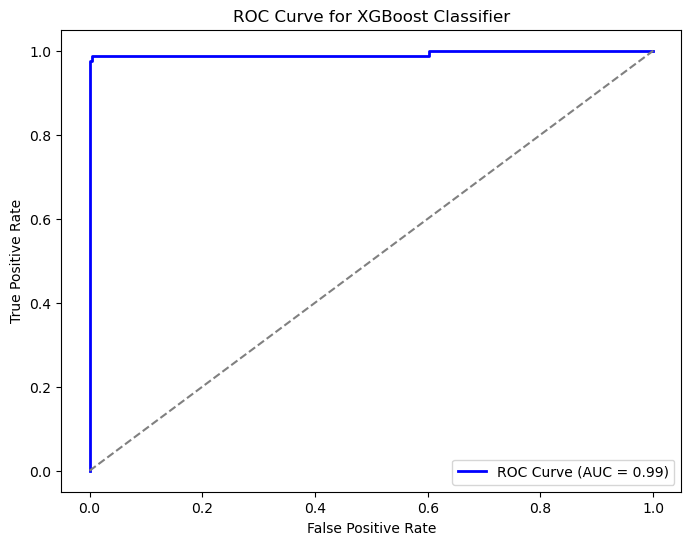

XGBoost Classifier - Feature Importance:

        Variable  absCoefficient
0     pack_unit        0.905782
4  TherapyClass        0.030708
3      Province        0.025130
1     TotalPaid        0.019554
2      DIN_Paid        0.018825 



In [41]:
# Predict on test data
y_pred_xgb = model_xgb.predict(X_test)
tn_xgb, fp_xgb, fn_xgb, tp_xgb = confusion_matrix(y_test, y_pred_xgb).ravel()

print(f"True Positives (TP): {tp_xgb}")
print(f"True Negatives (TN): {tn_xgb}")
print(f"False Positives (FP): {fp_xgb}")
print(f"False Negatives (FN): {fn_xgb}")

# Predict probabilities for ROC
y_probs_xgb = model_xgb.predict_proba(X_test)[:, 1]

# Plot Confusion Matrix
cnf_matrix_xgb = confusion_matrix(y_test, y_pred_xgb)

plot_confusion_matrix(cnf_matrix_xgb, classes = dict_characters,title='Confusion matrix')
plt.show()

# Compute ROC curve
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_probs_xgb)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_xgb, tpr_xgb, color = 'blue', lw=2, label=f'ROC Curve (AUC = {roc_auc_xgb:.2f})')
plt.plot([0, 1], [0, 1], color = 'gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for XGBoost Classifier')
plt.legend(loc='lower right')
plt.show()

# Feature importance
coefficients = model_xgb.feature_importances_.reshape(X.columns.shape[0], 1)
absCoefficients = abs(coefficients)
fullList = pd.concat(
    (pd.DataFrame(X.columns, columns=['Variable']),
     pd.DataFrame(absCoefficients, columns=['absCoefficient'])),
    axis=1
).sort_values(by='absCoefficient', ascending=False)

print('XGBoost Classifier - Feature Importance:')
print('\n', fullList, '\n')

As with all other models tested previously, pack unit is the most important feature of them all.

# **Model Comparison Summary**

We compare all the classification models used in this notebook with a focus on fraud detection. Since catching fraud is a top priority and stakeholders need interpretability, we focus on **Recall**, **F1 Score**, and **model explainability**.


In [42]:
# define a function to evaluate all the models on, taking in their true positive, true negative, false positive, false negative, y-test data, false positive
# rate, true positive rate, and the model name
def evaluate_model_from_confusion(tp, tn, fp, fn, y_test, fpr, tpr, name):
    # Derived metrics
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp) if (tp + fp) != 0 else 0
    recall = tp / (tp + fn) if (tp + fn) != 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) != 0 else 0
    auc_score = auc(fpr, tpr)


    return {
        'Model': name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'AUC': auc_score
    }

results = []

# Append results for logistic regression
results.append(evaluate_model_from_confusion(
    tp=tp_lr, tn=tn_lr, fp=fp_lr, fn=fn_lr,
    y_test=y_test, fpr = fpr_lr, tpr = tpr_lr,
    name="Logistic Regression"
))

# Append results for Random Forest
results.append(evaluate_model_from_confusion(
    tp=tp_rf, tn=tn_rf, fp=fp_rf, fn=fn_rf,
    y_test=y_test, fpr = fpr_rf, tpr = tpr_rf,
    name="Random Forest"
))

# Append results from AdaBoost
results.append(evaluate_model_from_confusion(
    tp=tp_ab, tn=tn_ab, fp=fp_ab, fn=fn_ab,
    y_test=y_test, fpr = fpr_ab, tpr = tpr_ab,
    name="AdaBoost"
))

# Append results for Decision Tree (Unpruned)
results.append(evaluate_model_from_confusion(
    tp=tp_dt, tn=tn_dt, fp=fp_dt, fn=fn_dt,
    y_test=y_test, fpr = fpr_dt, tpr = tpr_dt,
    name="Decision Tree"
))

# Append results for Decision Tree (Pruned)
results.append(evaluate_model_from_confusion(
    tp=tp_dt_pruned, tn=tn_dt_pruned, fp=fp_dt_pruned, fn=fn_dt_pruned,
    y_test=y_test, fpr = fpr_dt_pruned, tpr = tpr_dt_pruned,
    name="Pruned Decision Tree"
))

# Append results for K-Nearest Neighbours
results.append(evaluate_model_from_confusion(
    tp=tp_knn, tn=tn_knn, fp=fp_knn, fn=fn_knn, fpr = fpr_knn, tpr = tpr_knn,
    y_test=y_test,
    name="K-Nearest Neighbours"
))

# Append results for XGBoost
results.append(evaluate_model_from_confusion(
    tp=tp_xgb, tn=tn_xgb, fp=fp_xgb, fn=fn_xgb,
    y_test=y_test, fpr = fpr_xgb, tpr = tpr_xgb,
    name="XGBoost"
))

# get the results in a data frame for easy comparison
results_df = pd.DataFrame(results)
results_df.set_index('Model', inplace=True)
results_df

,Accuracy,Precision,Recall,F1 Score,AUC
Model,,,,,
Logistic Regression,0.993891,1.000000,0.880952,0.936709,0.983565
Random Forest,0.999389,1.000000,0.988095,0.994012,0.993089
AdaBoost,0.999389,1.000000,0.988095,0.994012,0.992921
Decision Tree,0.995113,0.922222,0.988095,0.954023,0.991794
Pruned Decision Tree,0.999389,1.000000,0.988095,0.994012,0.994048
K-Nearest Neighbours,0.991448,1.000000,0.858586,0.923913,0.953488
XGBoost,0.996946,0.964706,0.976190,0.970414,0.992779


# Discussion

In addition to our results, we also wanted to evaluate model mechanics of our top 3 models that had the best metrics. Understanding at the model mechanics to understand how they make their classification is important. Firstly, AdaBoost stands for adaptive boosting, and works by making a strong classifier by combining multiple weak ones. This works by each of the weak models learning from the previous ones mistakes, typically starting with decision trees (default) or logistic regression. It is therefore unsurprising that we saw Adaboost outperform both of these individual models.

The pruned tree, in this case, is a “stump” because it was "cut down" from our larger decision tree and only relies on one single classifier for two options. The single level decision tree may have performed well in this case due to  packed unit being so important, but generally they are weak due to simplicity, and are not recommended as stand alone models.

The random forest combines multiple decision trees (obtained by bootstrapping the data) to obtain a single result based on the result from the majority of trees. It is also unsurprising that we saw this outperform our decision tree.

With this information, method wise AdaBoost and Random forest have the most trustworthy mechanics compared to the pruned tree.

Evaluating the models, we see that on our metrics Adaboost did the best for each metric, followed by the pruned tree model, and then the random forest. The packed unit was the most important feature across all models. Again, Adaboost and Random forest have the most reliable methods. This lead to the decision that Adaboost was our top model, however for the purpose of our dashboard and user options, we also wanted to allow them to select other models like the pruned tree and random forest, since they still perform quite strongly.

Overall, all of our models performed well, with accuracies above 0.99. Despite this, only the best models across the metrics measured, feature importance, and model internal methods were selected for future use in the Dashboard.




# Business Impact

Insurance fraud has major financial implications. Costing $308 billion annually in the United States, with over ⅓ of this cost coming from healthcare related insurance fraud (1).

This makes up an estimated 3-10% of healthcare expenditure losses. This has an impact on both individuals and businesses. Of course businesses lose money, but the related increases of fees and taxes impacts both businesses and individuals (2).

Being able to detect fraud has a variety of impacts, again at a business and individual level. Of course, earlier detection and prevention or intervention can save money for both businesses and individuals, but beyond that it can also save resources and prevent unnecessary treatment, which may happen in cases of exploitation. Earlier fraud detection would also bring about legal action, which would stronger enforce the repercussions and implications of committing fraud, which would hopefully have a discouraging effect if people are considering committing fraud, due to a higher chance of being caught. Lastly, customer profiling is used often by insurance companies to assess risk levels of patients.  Companies may use customer profiling to get an idea of the customers risk; including things like biometric data, online behaviour, GPS activity, and other data they have access to (3). Using this information, combined with the data collected on customer actions surrounding purchases and claims, may give us the ability to create a more robust model that is capable of making better predictions than just one dealing with static data. Some methods that could be used are (long short-term memory) LSTM deep learning model, which deal with temporal data. More specific to this application though are MHGSL health insurance fraud detetcion methods, which were described in a 2024 paper by Hong et al., and specifically built using graphs to represent multiple levels of potential fraud detection, including the use of temporal data (3).

# References
1. Kilroy, A. (2024, March). Insurance fraud statistics 2024. Forbes Advisor. https://www.nasdaq.com/articles/insurance-fraud-statistics-2024#:~:text=Health%20Care%20Fraud%20Accounts%20for,From%20Medicare%20and%20Medicaid%20Fraud
2. National Health Care Anti-Fraud Association. (n.d.). The Challenge of Health Care  Fraud. Retrieved from https://www.nhcaa.org/tools-insights/about-health-care-fraud/the-challenge-of-health-care-fraud/
3. Hong et al. (2024, May). Health insurance fraud detection based on multi-channel heterogeneous graph structure learning. Science Direct. https://doi.org/10.1016/j.heliyon.2024.e30045


# **Dash App**

Creating an interactive web app to visualize the following aspects:
- Plots to visualize key insights.
- Model performance metrics within the Dash app.
- User interaction for viewing predictive results.

Main tab
*   Allow users to select model from dopdown (adaboost vs random forest vs pruned decision tree)
*   Allow user to test an existing claim from the dataset (Project1_data.csv) or a custom claim (input DIN_submitted, Qty, TotalPaid, DIN_Paid, Province, TherapyClass)
*   Show if the claim is fraud or not fraud.
*   Show accuracy metric at the bottom for the selected model


Second Tab
*   One tab showing all stats for each model. Show Confusion matrix + ROC curves + Accuracy metrics for the chosen model.

Third Tab ??
*   This should include EDA plots by fraud status for relevant variables (user can choose which variables they want to view the EDA plot for).

In [43]:
import dash
from dash import dcc, html, Input, Output, State
import dash_bootstrap_components as dbc
import numpy as np
import joblib
import plotly.express as px
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report

# Save your raw dataframe
joblib.dump(data, "raw_df.pkl")  # assumes 'data' is your cleaned dataframe

# Save the test split
joblib.dump((X_test, y_test), "test_split.pkl")

# Save models
joblib.dump(model_dt_pruned, "model_dt_pruned.pkl")
joblib.dump(model_rf, "model_rf.pkl")
joblib.dump(model_ab, "model_ab.pkl")

# Loading data and models
df_raw = joblib.load("raw_df.pkl")
X_test, y_test = joblib.load("test_split.pkl")
model_dict = {
    "Pruned Decision Tree": joblib.load("model_dt_pruned.pkl"),
    "Random Forest":         joblib.load("model_rf.pkl"),
    "AdaBoost":              joblib.load("model_ab.pkl")
}

# Ascending claims for drop-down menu
sorted_claims = sorted(X_test.index)

model_accuracy = {
    "Pruned Decision Tree": 0.9994,
    "Random Forest":        0.9994,
    "AdaBoost":             0.9994
}

province_encoder = {'AB':0,'ON':1,'MB':2,'BC':3,'QC':4}
therapyclass_encoder = {
    'Antidiabetics':0,'Antibiotics':1,'Antihypertensives':2,
    'Cholesterol Reducers':3,'Antiinflammatories':4,'Respiratory':5,
    'Analgesics':6,'Gastrointestinal':7,'Hormonal':8,'Antidepressants':9
}

# Initializing the Dash app
app = dash.Dash(
    __name__,
    external_stylesheets=[dbc.themes.YETI],
    suppress_callback_exceptions=True
)

# Dash app layout
app.layout = html.Div(
    style={"backgroundColor": "#d0e7f9", "minHeight": "100vh", "padding": "0"},
    children=[
        dbc.Container(
            fluid=True,
            style={"maxWidth": "1200px", "margin": "auto", "padding": "20px"},
            children=[
                html.H2(
                    "Pharmacy Fraud Detection",
                    style={"textAlign": "center", "color": "#2C3E50", "marginBottom": "20px", "fontWeight": "900"}
                ),

                dcc.Tabs(
                    id="tabs", value="tab-1",
                    children=[
                        dcc.Tab(
                            label="Predict a Claim", value="tab-1",
                            style={"padding": "10px"},
                            selected_style={"backgroundColor": "#008CBA", "color": "white"}
                        ),
                        dcc.Tab(
                            label="Model Performance", value="tab-2",
                            style={"padding": "10px"},
                            selected_style={"backgroundColor": "#008CBA", "color": "white"}
                        ),
                        dcc.Tab(
                            label="EDA by Fraud Status", value="tab-3",
                            style={"padding": "10px"},
                            selected_style={"backgroundColor": "#008CBA", "color": "white"}
                        ),
                    ],
                    style={"marginBottom": "20px"}
                ),

                html.Div(id="tabs-content")
            ]
        )
    ]
)

# Rendering the tab contents
@app.callback(Output("tabs-content", "children"),
              Input("tabs", "value"))
def render_tab_content(tab):

    # Tab 1: Predict a Claim
    if tab == "tab-1":
        options = [{"label": str(i+1), "value": cid}
                   for i, cid in enumerate(sorted_claims)]

        return dbc.Card(
            style={"backgroundColor": "#f0f8ff"},
            className="shadow-sm p-4 mb-4 rounded",
            children=[
                dbc.CardBody([
                    html.H4("Select Model", style={"textAlign": "center", "color": "#34495E"}),
                    dcc.Dropdown(
                        id="model-select",
                        options=[{"label": k, "value": k} for k in model_dict],
                        value="Pruned Decision Tree",
                        className="mb-3"
                    ),

                    html.H5(
                        "Select Existing Claim or Enter a Custom Claim:",
                        style={"textAlign": "center", "marginTop": "20px"}
                    ),
                    dcc.Dropdown(
                        id="existing-claim-dropdown",
                        options=options,
                        placeholder="Pick a claim number…",
                        className="mb-3"
                    ),

                    html.Div("Or enter manually:", style={"textAlign": "center", "marginBottom": "10px"}),
                    dbc.Row([
                        dbc.Col([dbc.Label("DIN_Submitted"), dcc.Input(id="input-DIN_Submitted", type="number", value=0)]),
                        dbc.Col([dbc.Label("Qty"),           dcc.Input(id="input-Qty",           type="number", value=1)]),
                        dbc.Col([dbc.Label("TotalPaid"),     dcc.Input(id="input-TotalPaid",     type="number", value=0)]),
                        dbc.Col([dbc.Label("DIN_Paid"),      dcc.Input(id="input-DIN_Paid",      type="number", value=0)]),
                        dbc.Col([dbc.Label("Province"),      dcc.Dropdown(id="input-Province", options=[{"label":p,"value":p} for p in province_encoder], value="ON")]),
                        dbc.Col([dbc.Label("TherapyClass"),  dcc.Dropdown(id="input-TherapyClass", options=[{"label":t,"value":t} for t in therapyclass_encoder], value="Antibiotics")]),
                    ], className="g-3 mb-3"),
                    html.Div(
                        dbc.Button("PREDICT", id="predict-button", color="primary", size="lg"),
                        style={"textAlign": "center", "marginTop": "20px", "marginBottom": "20px"}
                    ),

                    html.Div(id="prediction-output", style={"fontSize": 24, "textAlign": "center"}),
                    html.Div(id="accuracy-display",  style={"fontSize": 18, "color": "gray", "textAlign": "center"})
                ])
            ]
        )

    # Tab 2: Model Performance
    elif tab == "tab-2":
        return dbc.Card(
            style={"backgroundColor": "#f0f8ff"},
            className="shadow-sm p-4 mb-4 rounded",
            children=[
                dbc.CardBody([
                    html.H4("Model Performance Comparison", style={"textAlign": "center", "color": "#34495E"}),
                    dcc.Dropdown(
                        id="model-metrics-select",
                        options=[{"label": k, "value": k} for k in model_dict],
                        value="Pruned Decision Tree",
                        className="mb-4"
                    ),
                    dbc.Row([dbc.Col(dcc.Graph(id="confusion-matrix-plot")), dbc.Col(dcc.Graph(id="roc-curve-plot"))]),
                    html.Div(id="metrics-output", style={"fontSize": 16, "marginTop": "20px", "textAlign": "center"})
                ])
            ]
        )

    # Tab 3: EDA by Fraud Status
    else:
        return dbc.Card(
            style={"backgroundColor": "#f0f8ff"},
            className="shadow-sm p-4 mb-4 rounded",
            children=[
                dbc.CardBody([
                    html.H4("Exploratory Data Analysis by Fraud Status", style={"textAlign": "center", "color": "#34495E"}),
                    html.P("Select a variable to visualize by fraud status:", style={"textAlign": "center"}),
                    dcc.Dropdown(
                        id="eda-variable-select",
                        options=[{"label": c, "value": c}
                                 for c in df_raw.columns
                                 if c not in ["ClaimID", "ClaimantID", "IsFraud", "DIN"]],
                        placeholder="Choose a variable…",
                        className="mb-4"
                    ),
                    dcc.Graph(id="eda-plot")
                ])
            ]
        )

# Callback for Tab 1
@app.callback(
    [Output("prediction-output", "children"), Output("accuracy-display", "children")],
    Input("predict-button", "n_clicks"),
    State("model-select", "value"),
    State("existing-claim-dropdown", "value"),
    State("input-DIN_Submitted", "value"),
    State("input-Qty", "value"),
    State("input-TotalPaid", "value"),
    State("input-DIN_Paid", "value"),
    State("input-Province", "value"),
    State("input-TherapyClass", "value")
)
def predict_fraud(nc, mdl, cid, din_s, qty, tot, din_p, prov, ther):
    if not nc:
        return "", ""
    if cid is not None:
        r = X_test.loc[cid]
        pu, tp, dp, pr, th = r["pack_unit"], r["TotalPaid"], r["DIN_Paid"], r["Province"], r["TherapyClass"]
    else:
        pu = din_s/qty if qty else 0
        tp, dp, pr, th = tot or 0, din_p or 0, prov, ther
    pe = province_encoder.get(pr, -1)
    te = therapyclass_encoder.get(th, -1)
    arr = np.array([[pu, tp, dp, pe, te]])
    p = model_dict[mdl].predict(arr)[0]
    label = "FRAUDULENT" if p == 1 else "NOT FRAUDULENT"
    acc = model_accuracy[mdl] * 100
    return label, f"NOTE: The accuracy for the selected model is {acc:.2f}%"

# Callback for Tab 2
@app.callback(
    [Output("confusion-matrix-plot", "figure"),
     Output("roc-curve-plot", "figure"),
     Output("metrics-output", "children")],
    Input("model-metrics-select", "value")
)
def update_model_performance(mdl):
    m = model_dict[mdl]
    yp = m.predict(X_test)
    pr = m.predict_proba(X_test)[:, 1]
    cm = confusion_matrix(y_test, yp)
    cm_fig = px.imshow(cm, text_auto=True, color_continuous_scale="Blues",
                       labels={"x": "Predicted", "y": "Actual"})
    cm_fig.update_layout(title=f"Confusion Matrix — {mdl}", title_x=0.5)
    fpr, tpr, _ = roc_curve(y_test, pr)
    roc_auc = auc(fpr, tpr)
    roc_fig = px.area(x=fpr, y=tpr,
                      title=f"ROC Curve — {mdl} (AUC = {roc_auc:.2f})",
                      labels={"x": "False Positive Rate", "y": "True Positive Rate"},
                      template="plotly_white")
    roc_fig.update_layout(title_x=0.5)
    rpt = classification_report(y_test, yp, output_dict=True)
    txt = (f"Accuracy: {rpt['accuracy']:.2f} | "
           f"Precision (Fraud): {rpt['1']['precision']:.2f} | "
           f"Recall (Fraud): {rpt['1']['recall']:.2f} | "
           f"F1-score (Fraud): {rpt['1']['f1-score']:.2f}")
    return cm_fig, roc_fig, txt

# Callback for Tab 3
@app.callback(
    Output("eda-plot", "figure"),
    Input("eda-variable-select", "value")
)
def update_eda_plot(var):
    if not var:
        return {}
    df = df_raw.loc[X_test.index].copy()
    df["IsFraud"] = y_test.values
    cats = ["PharmacyChainName","PharmacyName","City","Province","TherapyClass","Postcode"]
    if var in cats:
        fig = px.histogram(df, x=var, color="IsFraud", barmode="group",
                           title=f"{var} Distribution by Fraud Status",
                           labels={"IsFraud":"Fraud", var:var},
                           template="plotly_white")
    else:
        fig = px.box(df, x="IsFraud", y=var, color="IsFraud",
                     title=f"{var} by Fraud Status",
                     labels={"IsFraud":"Fraud", var:var},
                     template="plotly_white")
    fig.update_layout(title_x=0.5, transition_duration=300)
    return fig

if __name__ == "__main__":
    app.run(debug=True)